In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt, ceil
import csv

class ELM_model:
    
    def __init__(self,data,labels,hidden_size,activation="relu",distribution="rand"):
        self.data = data
        self.labels = labels
        self.hidden_size=hidden_size
        if(activation=="relu"):
            self.activation=self.relu
        elif(activation=="sigmoid"):
            self.activation=self.sigmoid
        else:
            print("Error: no such activation rule implemented")
            return()
        
        #create model
        _, input_size = self.data.shape
        if(distribution=="rand"):
            self.input_weights = np.random.rand(input_size,hidden_size)*2-1
            self.biases = np.random.rand(hidden_size)*2-1
        elif(distribution=="normal"):
            self.input_weights = np.random.normal(size=[input_size,hidden_size])
            self.biases = np.random.normal(size=[hidden_size])
        else:
            print("Error: unknown distribution option")
            return()
        H = self.hidden_nodes(self.data)
        self.output_weights = np.dot(np.linalg.pinv(H), self.labels)            
  
    def hidden_nodes(self,X):
        G = np.dot(X, self.input_weights)
        G = G + self.biases
        H=self.activation(G)
        return H
  
    def predict(self,X):
        out = self.hidden_nodes(X)
        out = np.dot(out, self.output_weights)
        return out        
            
    def relu(self,x):
       return np.maximum(x, 0, x)

    def sigmoid(self,z):
        return 1/(1 + np.exp(-z))
            
def normalize(A,option): #normalizing an array
    _,m=A.shape
    
    #lower and upper bounds joint angles
    lb_theta = np.array([0,-30,-30,-180,-90,-180])*np.pi/180;   
    ub_theta = np.array([90,60,30,180,90,180])*np.pi/180;     
    df_theta = ub_theta-lb_theta
    
    #lower and upper bounds force
    lb_force = np.array([-2000,-2000,-2000,0,0,0]); ub_force = np.array([2000,2000,2000,0,0,0]); df_force=ub_force-lb_force
    
    #lower and upper bounds of absolute pose xyz coordinates
    lb_pose = np.array([-1,-1,-1]); ub_pose = np.array([3,3,3]); df_pose=ub_pose-lb_pose          
    
    #lower and upper bounds of quaternions
    lb_quat=np.array([-1,-1,-1,-1]); ub_quat=np.array([1,1,1,1]); df_quat=ub_quat-lb_quat
    
    # relative pose and angular error shall not be normalized
    offset_z = np.array([0,0,0]); length_z=np.array([1,1,1])
    
    if (option=="minmax"):
        offset=[np.min(A[:,i:i+1]) for i in range(m)]
        length=[np.max(A[:,i:i+1])-np.min(A[:,i:i+1]) for i in range(m)]
    
    elif(option=="standard"):
        offset=[np.mean(A[:,i:i+1]) for i in range(m)]
        length=[np.std(A[:,i:i+1]) for i in range(m)]        
    
    elif(option=="dataset1"): #dataset 1 
        # input (6): six joint angles (rad); 
        # output (7): absolute pose xyz, i.e. position (m) and quaternions
        offset=np.concatenate((lb_theta, lb_pose,lb_quat))
        length=np.concatenate((df_theta, df_pose, df_quat))
    
    elif(option=="dataset2"): #dataset 2 
        # input (12): six joint angles (rad), wrench vector (force(N), torque(Nm)=zeros)
        # output (7): absolute pose, i.e. position (m) and quaternions
        offset = np.concatenate((lb_theta, lb_force, lb_pose, lb_quat))
        length = np.concatenate((df_theta, df_force, df_pose, df_quat))        

    elif(option=="dataset3"): #dataset 3 
        # input (12): six joint angles (rad), wrench vector (force(N), torque(Nm)=zeros)
        # output (7): relative pose, i.e. position error (m) and quaternion error
        offset = np.concatenate((lb_theta, lb_force, offset_z, lb_quat))
        length = np.concatenate((df_theta, df_force, length_z, df_quat))                
        
    elif(option=="dataset4"): #dataset 4 
        # input (6): six joint angles (rad)
        # intput (7): absolute pose, i.e. position (m) and quaternions
        offset = np.concatenate((lb_theta, lb_pose, lb_quat))
        length = np.concatenate((df_theta, df_pose, df_quat))            
        
    elif(option=="dataset5"): #dataset 5 
        # input (6): six joint angles (rad)
        # output (6): relative pose, i.e. position error (m) and angular error (rad)
        offset = np.concatenate((lb_theta, offset_z, offset_z))
        length = np.concatenate((df_theta, length_z, length_z))

    elif(option=="dataset6"): #dataset 6 
        # input (9): six joint angles (rad), force vector (N)
        # output (6): absolute pose, i.e. position (m) and angular error (rad)
        offset=np.concatenate((lb_theta, lb_force[:3],lb_pose,offset_z))
        length=np.concatenate((df_theta, df_force[:3],df_pose,length_z))        
    
    elif(option=="none"): #no normalization
        offset=np.zeros(m)
        length=np.zeros(m)
        
    else:
        print("Error: unknown option for normalization")                
        raise Exception("")
        
    for i in range(m):
        if(length[i]!=0):
            A[:,i:i+1] = (A[:,i:i+1]-offset[i])/length[i]        

    return(offset,length)

        
def denormalize(A,offset,length): #normalizing an array
    _,m=A.shape
    for i in range(m):
        if(length[i]!=0):
            A[:,i:i+1] = A[:,i:i+1]*length[i] + offset[i]
    
    
def error_prediction(filename, inputs=9, normalization="standard", neurons=100, activation="relu",distribution="rand",xlim=10,n_bins=400):
    dataframe = np.loadtxt(filename,delimiter=",")
    m,N=dataframe.shape
    
    #normalization
    offset, length = normalize(dataframe,normalization)
    
    #data splitting
    data = dataframe[:,:inputs]
    labels= dataframe[:,inputs:]
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20, random_state=42)

    #create model
    model=ELM_model(data_train,labels_train,neurons,activation,distribution)

    #predict
    prediction=model.predict(data_test)

    #denormalization    
    denormalize(prediction, offset, length)
    denormalize(labels_test, offset, length)

    return(prediction-labels_test)    

def print_prediction(filename, inputs=9, normalization="standard", neurons=100, activation="relu",distribution="rand", xlim=10,n_bins=400):
    
    diff = error_prediction(filename, inputs, normalization, neurons, activation,distribution,xlim,n_bins)                                   
    
    # Convert from m in mm
    diff=diff*1000
    
    figure,axis=plt.subplots(1,3)
    figure.set_figwidth(50)
    figure.set_figheight(20)        
    maximum={}
    mean={}
    stderiv={}
    XLabels=["X error in mm", "Y error in mm", "Z error in mm"]    
    for i in range(3):        
        maximum[i]=np.max(abs(diff[:,i:i+1]))
        mean[i]=np.mean(diff[:,i:i+1])
        stderiv[i]=np.std(diff[:,i:i+1])
        axis[i].hist(abs(diff[:,i:i+1]),n_bins)
        axis[i].set_xlim(0,xlim)        
        axis[i].set_xlabel(XLabels[i])        
    plt.show()     
    label=["X","Y","Z"]
    print('{:<25}{:^25}{:>25}'.format("Maximum","Mean","StDerv"))
    print('{:<25}{:^25}{:>25}'.format("-----","-----","-----"))    
    for i in range(3):
        print(label[i],'{:<25}{:^25}{:>25}'.format(str(maximum[i]),str(mean[i]),str(stderiv[i])))
        
    absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
    print("Average absolute positional error in mm: ", np.average(absolute))

def loss(filename, inputs=9, normalization="standard", neurons=100, activation="relu",distribution="rand",xlim=10,n_bins=400):
    diff = error_prediction(filename, inputs, normalization, neurons, activation,distribution,xlim,n_bins)*1000
    absolute=[np.sqrt(diff[i,0]**2 + diff[i,1]**2 + diff[i,2]**2) for i in range(len(diff))]
    return(np.mean(absolute))

In [2]:
def searchTheBest(i,a,b=300,size=1):
    Datasets_input=[0,6,12,12,6,6,9]
    inputs=Datasets_input[i]
    print("Looking at Dataset",i," with ",inputs, " input neurons.")
    dataset="dataset"+str(i)
    filename="datasets/"+dataset+".csv"
    L=[loss(filename,inputs=inputs,normalization=dataset,neurons=x,activation="sigmoid") for x in range(a,b)]
    minloss=min(L)
    neurons=L.index(minloss)+a
    print("Neurons:",neurons," Loss: ", minloss)
    print_prediction(filename,inputs=inputs,normalization=dataset,neurons=neurons,activation="sigmoid",distribution="rand",xlim=size)        

def trainDataSet(i,neurons,distribution,size):
    Datasets_input=[0,6,12,12,6,6,9]
    inputs=Datasets_input[i]
    dataset="dataset"+str(i)
    filename="datasets/"+dataset+".csv"    
    print_prediction(filename,inputs=inputs,normalization=dataset,neurons=neurons,activation="sigmoid",distribution=distribution,xlim=size)        

Looking at Dataset 4  with  6  input neurons.
Neurons: 234  Loss:  0.0214967754440146


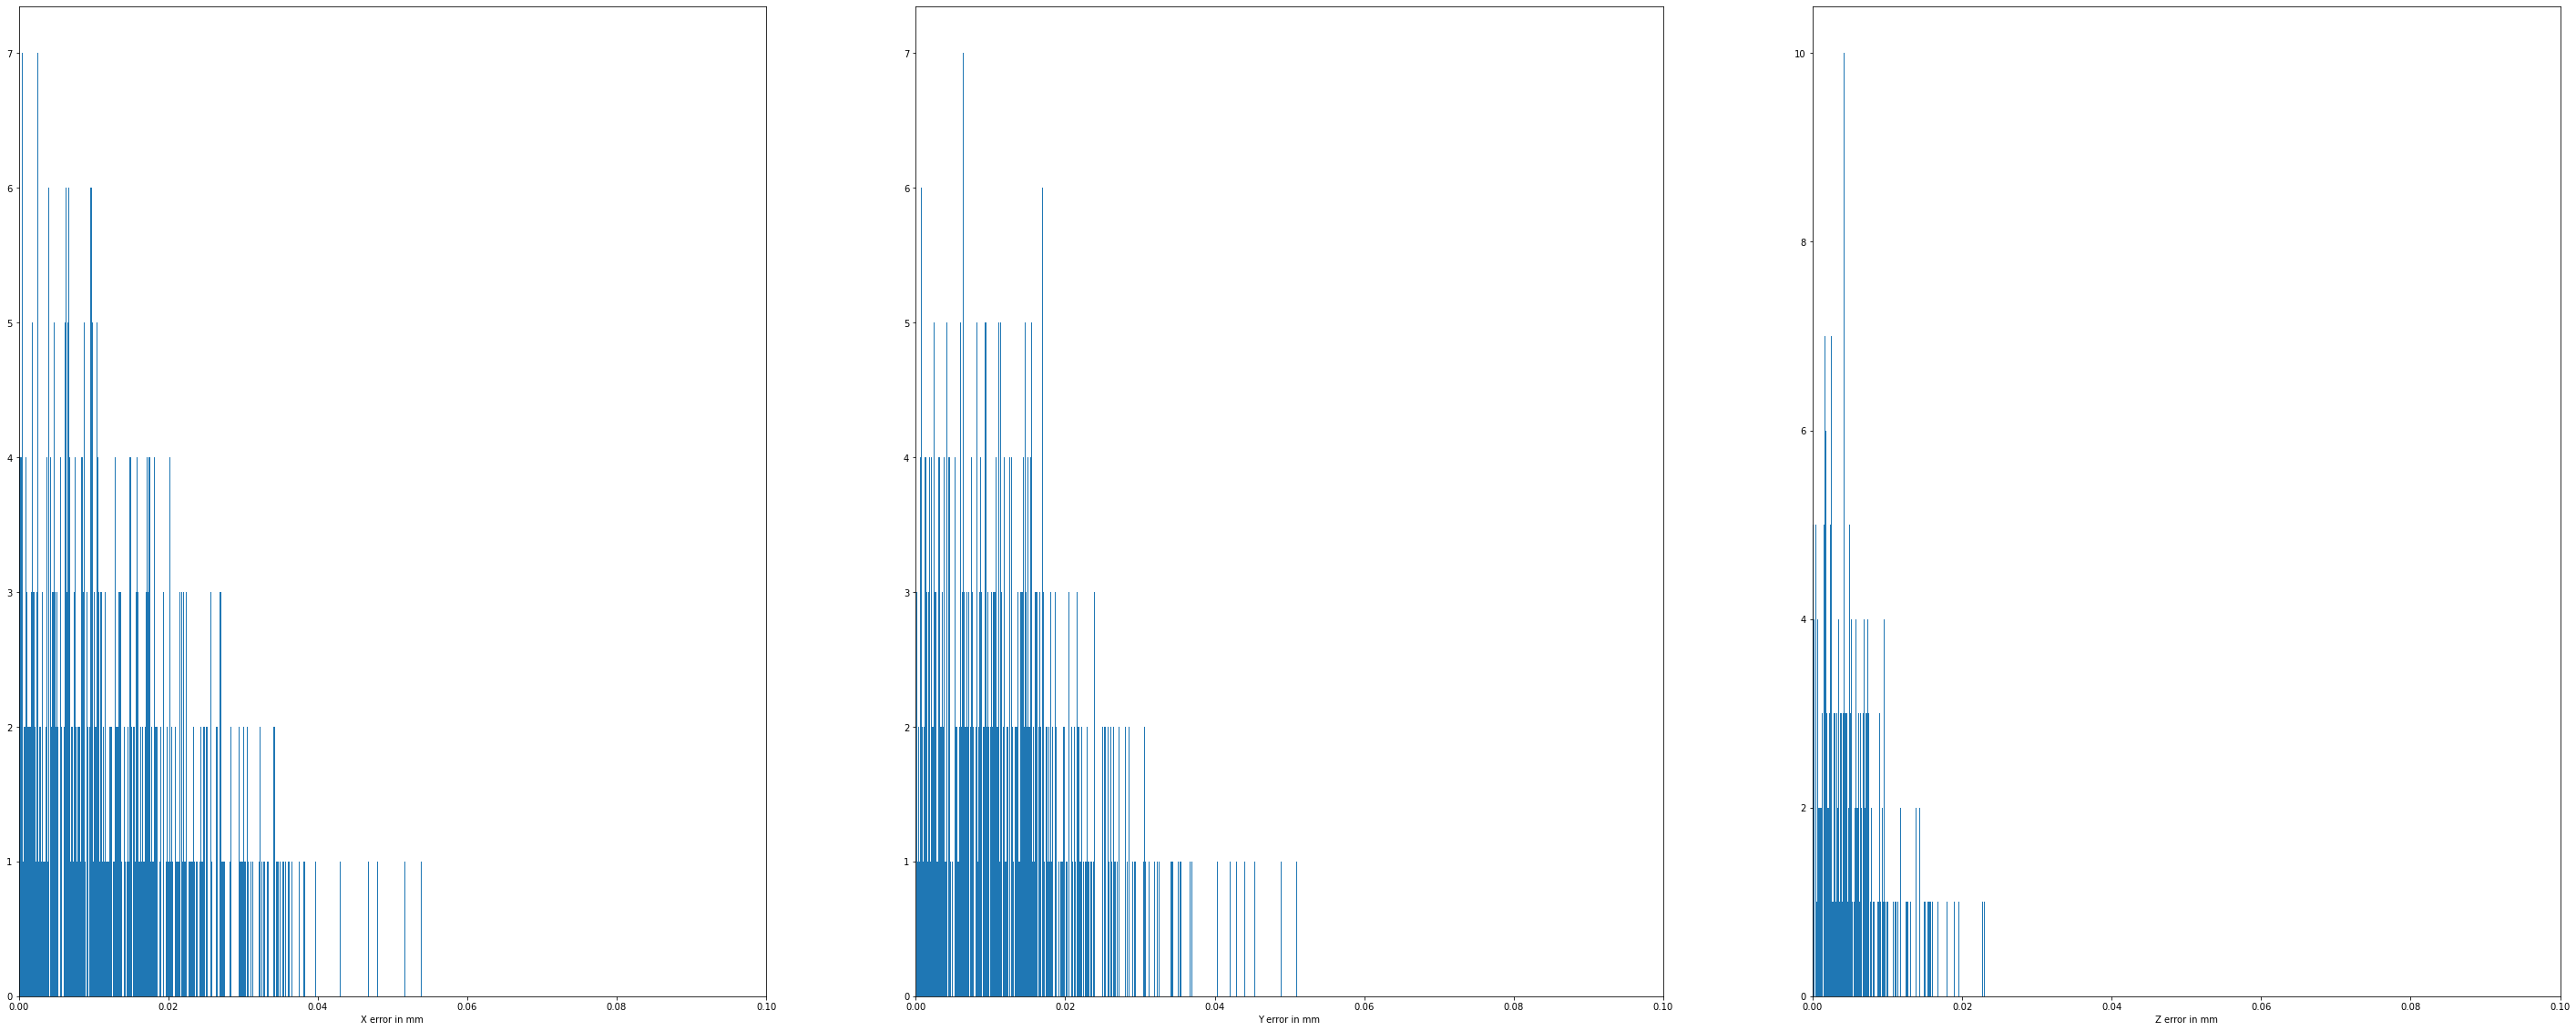

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.05390102432900612        6.184791762178278e-05       0.016929539726717867
Y 0.05102034818849077       0.00014471202337825912       0.015735906552832815
Z 0.025374246117093602       0.0004352038488017242       0.007375481417208855
Average absolute positional error in mm:  0.022018615296706952


In [64]:
searchTheBest(4,70,size=0.1)

Looking at Dataset 5  with  6  input neurons.
Neurons: 252  Loss:  0.07535063641745132


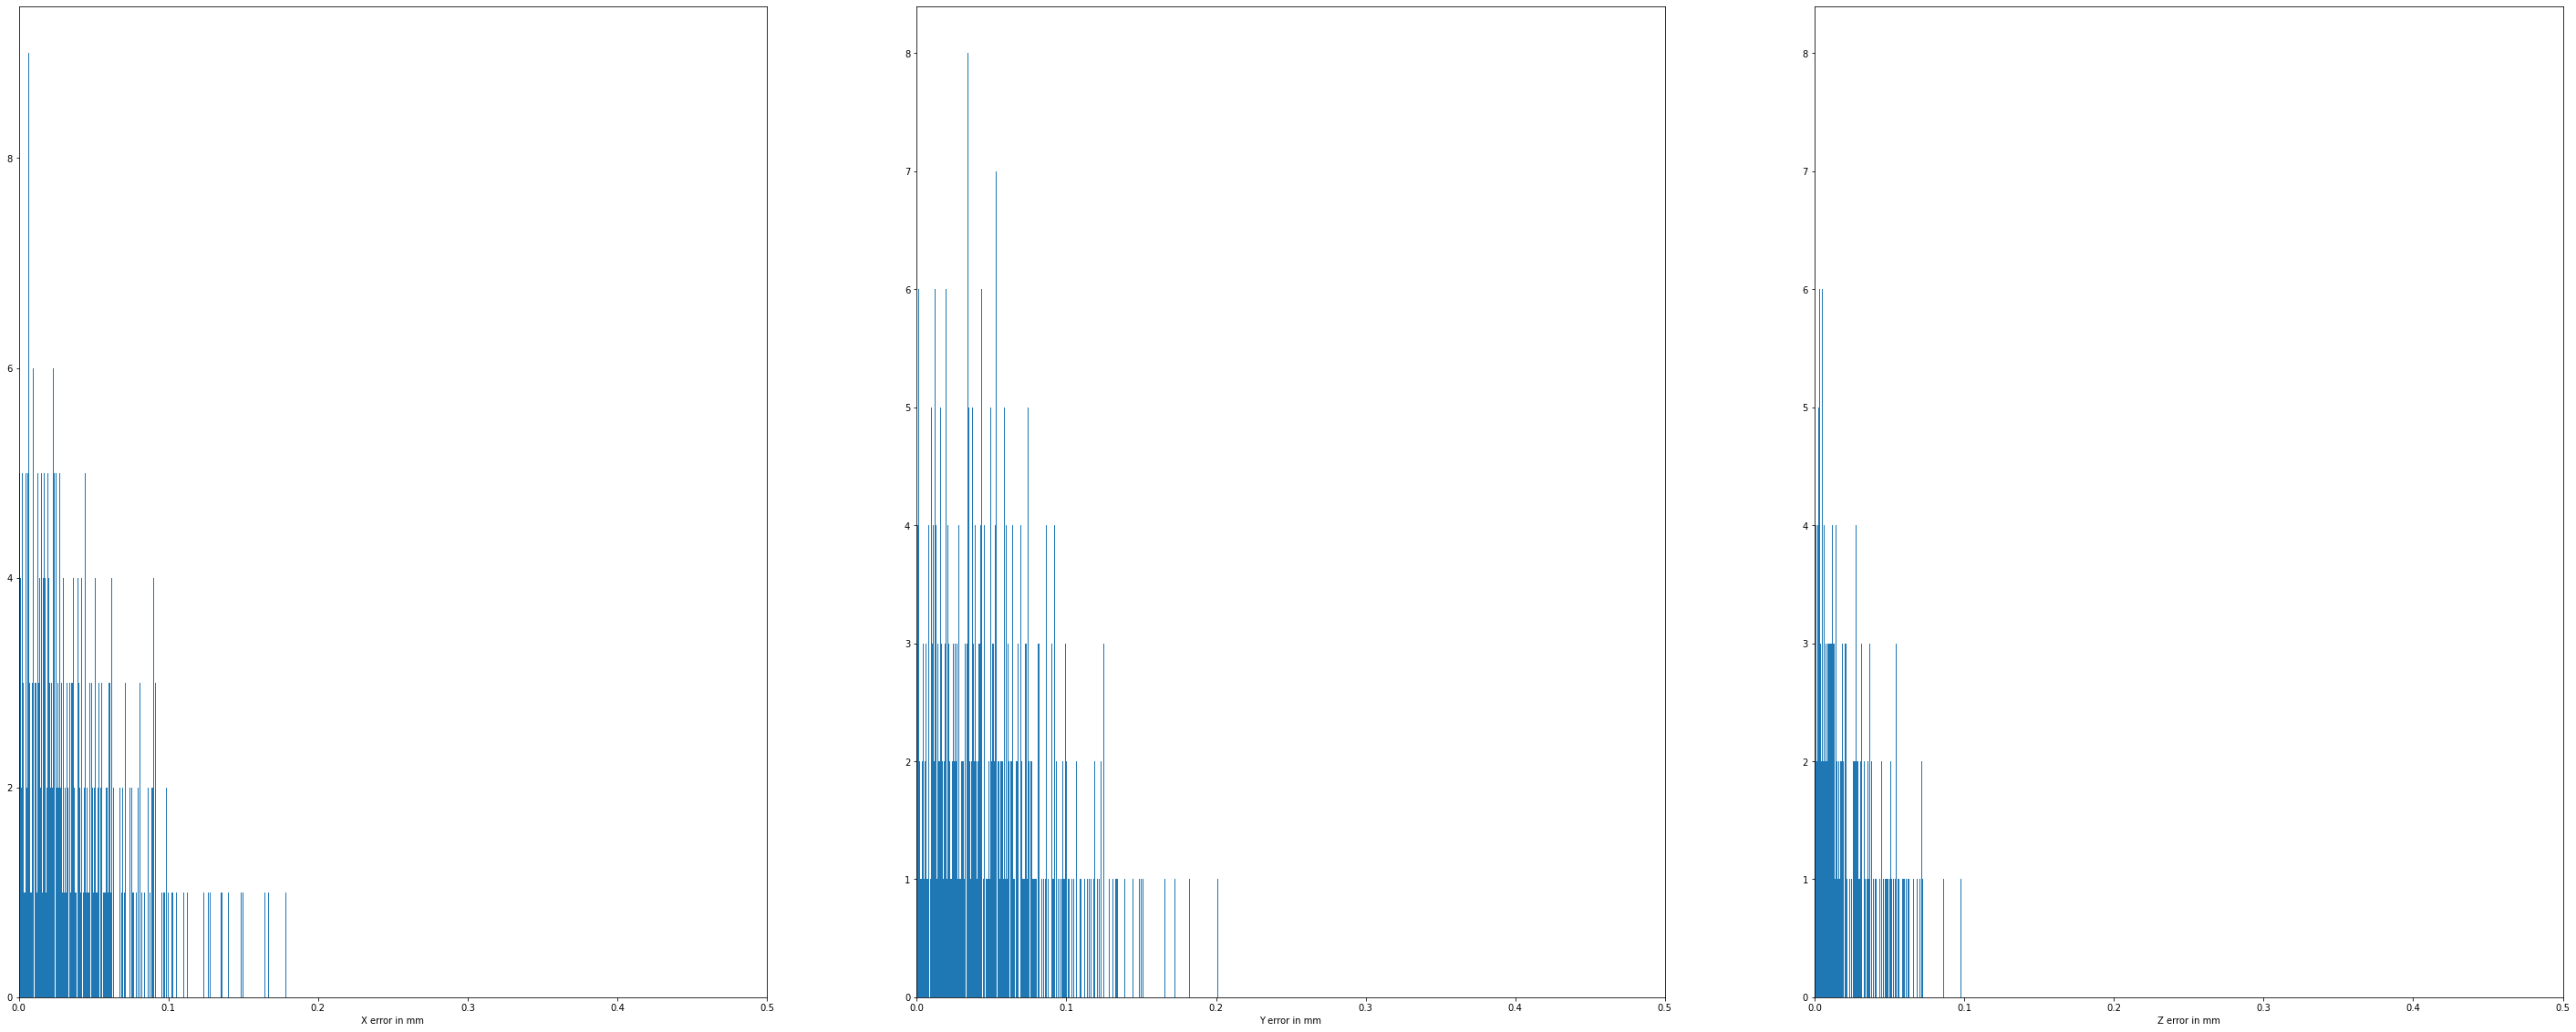

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.17861748676516534        0.0009618109256503976        0.05024570473039164
Y 0.20135076839955524        0.0006575457905095648        0.06277755440686464
Z 0.09789010809857501         0.00284671481447925         0.02870072928251955
Average absolute positional error in mm:  0.07684655913843223


In [66]:
searchTheBest(5,30,size=0.5)

Looking at Dataset 6  with  9  input neurons.
Neurons: 80  Loss:  0.026970932611624965


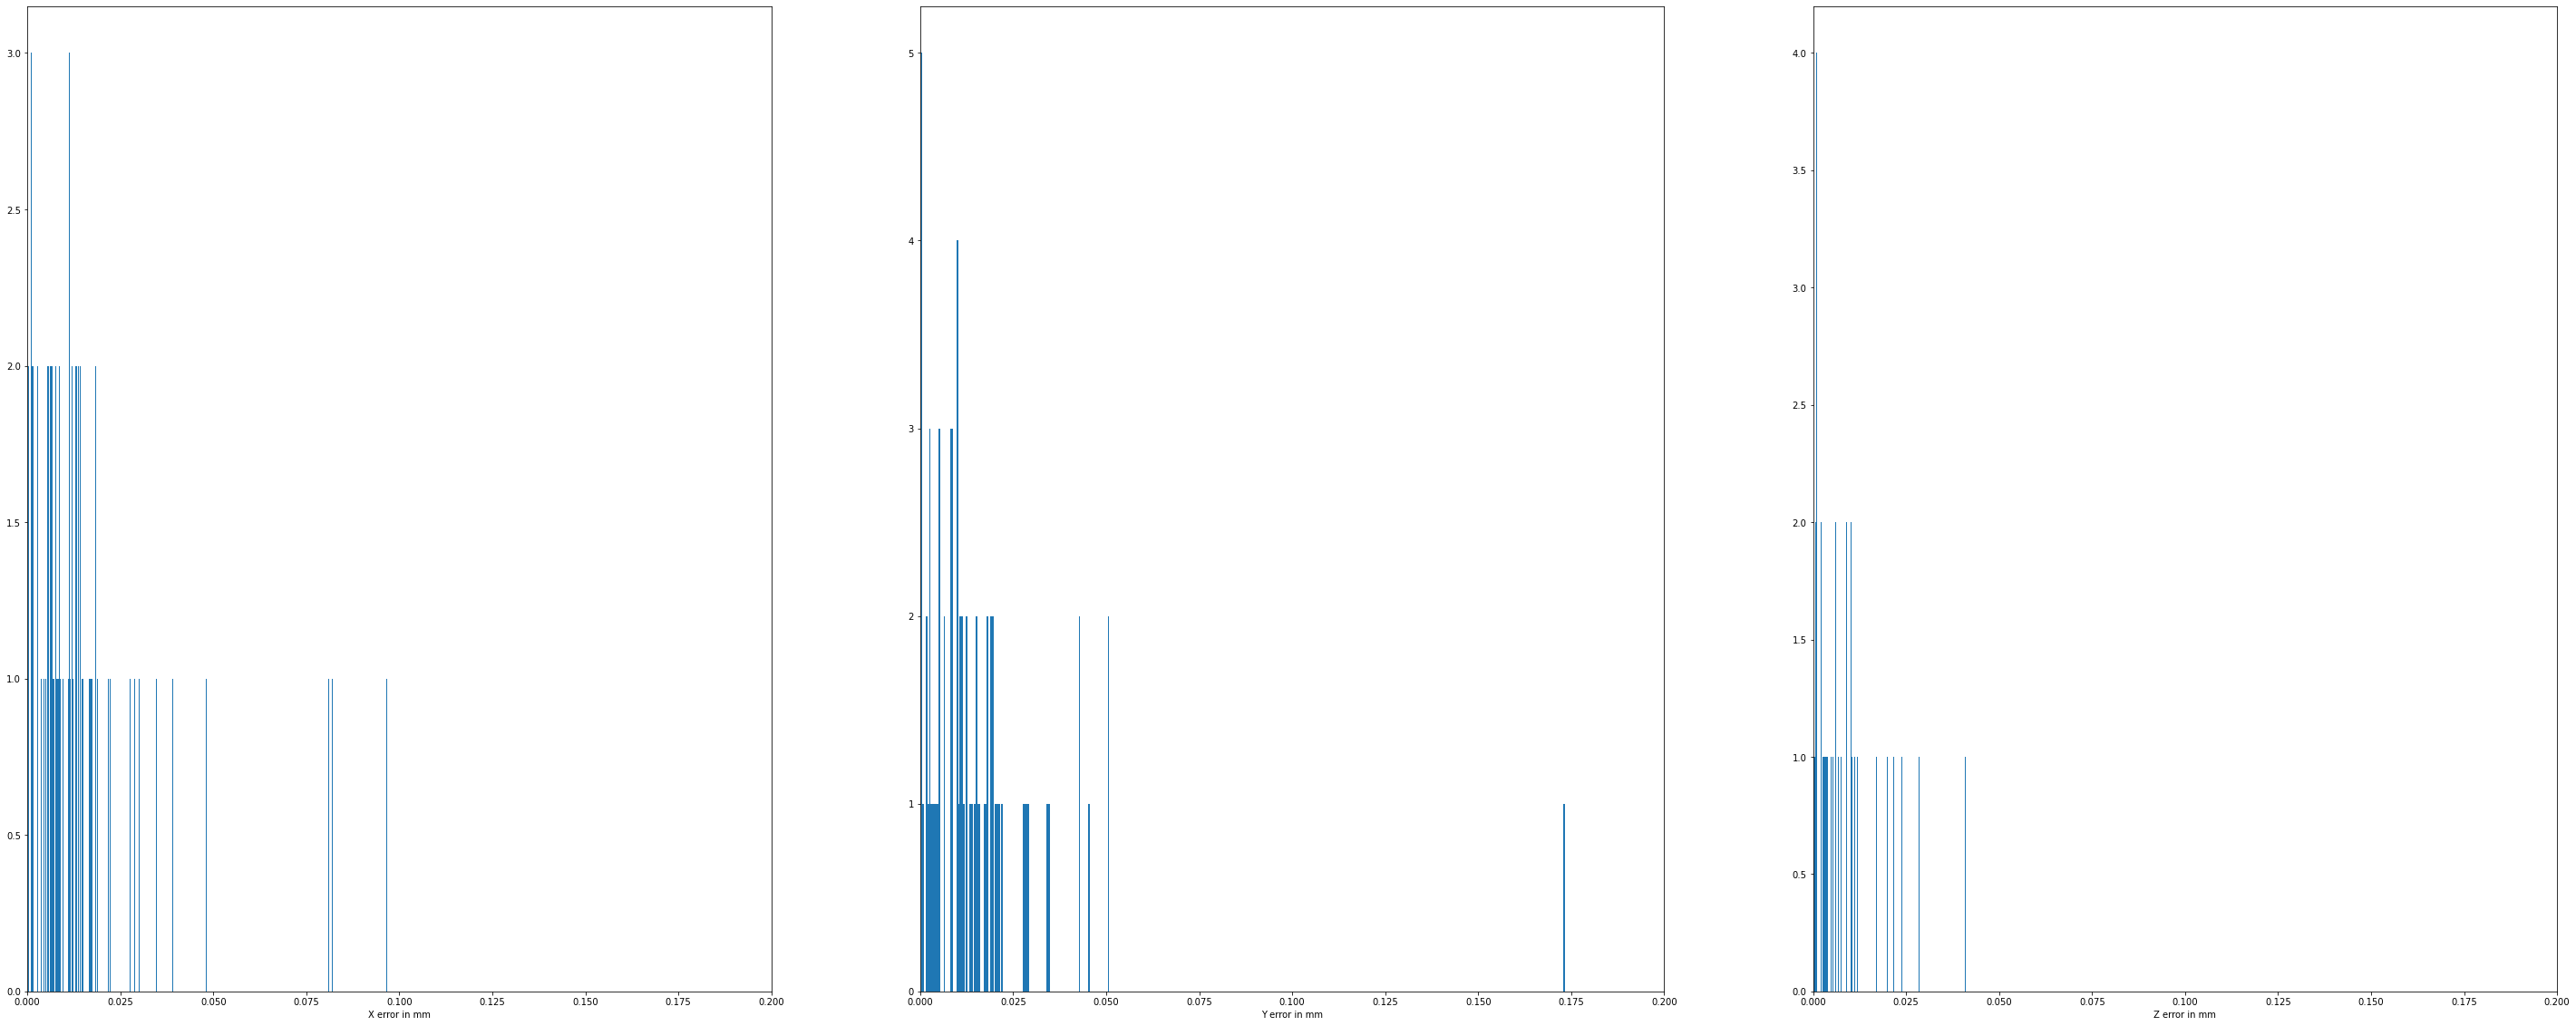

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.09676197201147207        0.0026627504705518104       0.022819733696630644
Y 0.17322135584180165       -5.818164942472983e-05        0.02776236473047315
Z 0.05261754989677181        0.0011924222911226655       0.013374004674856063
Average absolute positional error in mm:  0.027699946716901337


In [3]:
searchTheBest(6,20,b=400,size=0.2)

Looking at Dataset 3  with  12  input neurons.
Neurons: 293  Loss:  0.37532634182599645


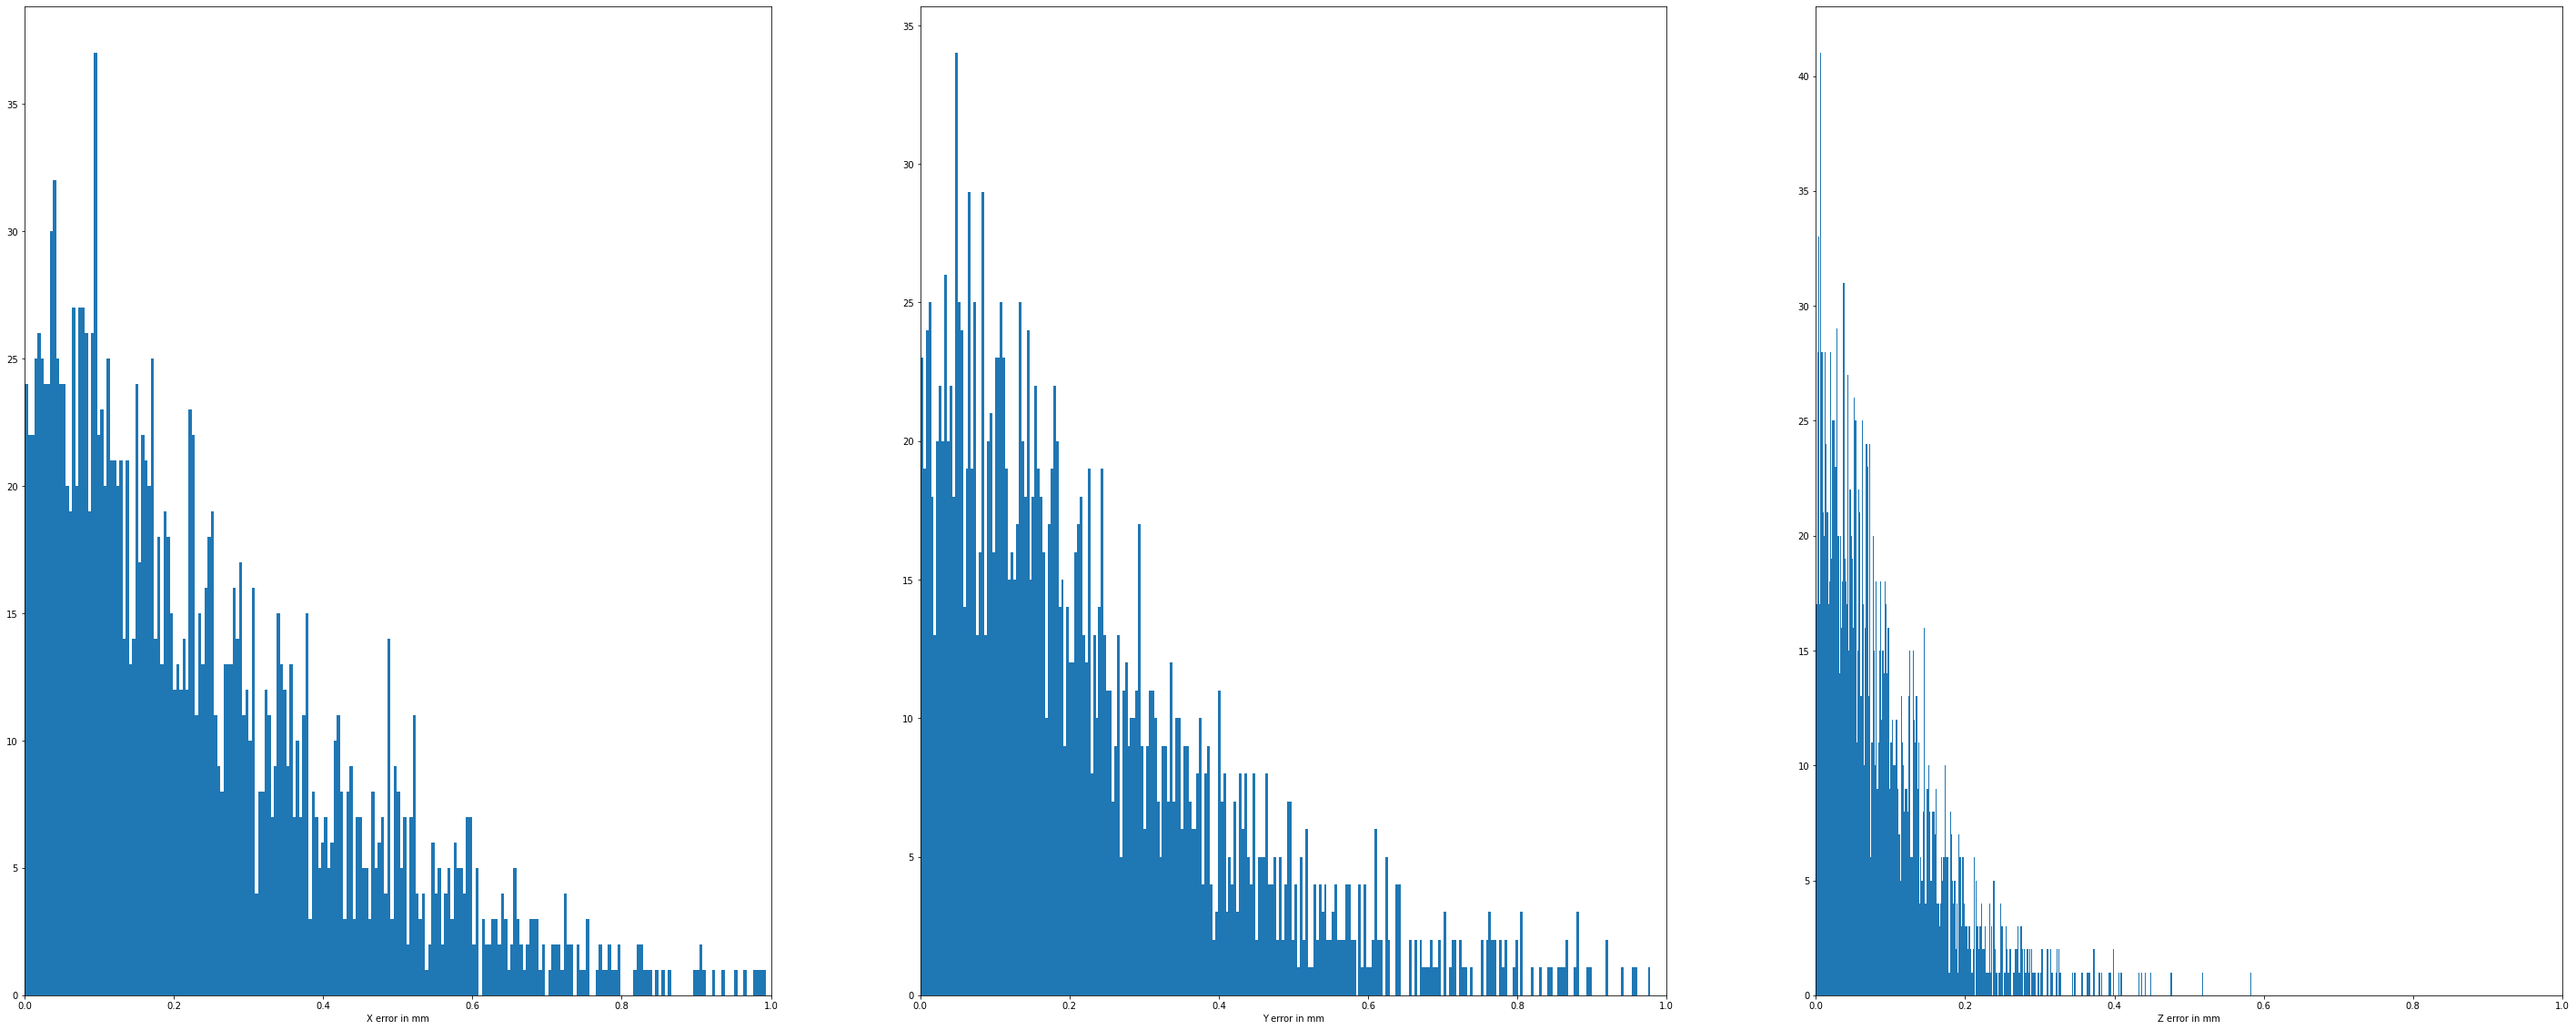

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 1.6899181988508623        0.00015257810499390967         0.3254278338496293
Y 1.4229368221545524         -0.003062644708022255         0.3096116224544698
Z 0.5832168569017693         0.0003099480822976175         0.1173811166296755
Average absolute positional error in mm:  0.39582789529107015


In [3]:
searchTheBest(3,10,size=1)

Looking at Dataset 2  with  12  input neurons.
Neurons: 295  Loss:  40.96095131978535


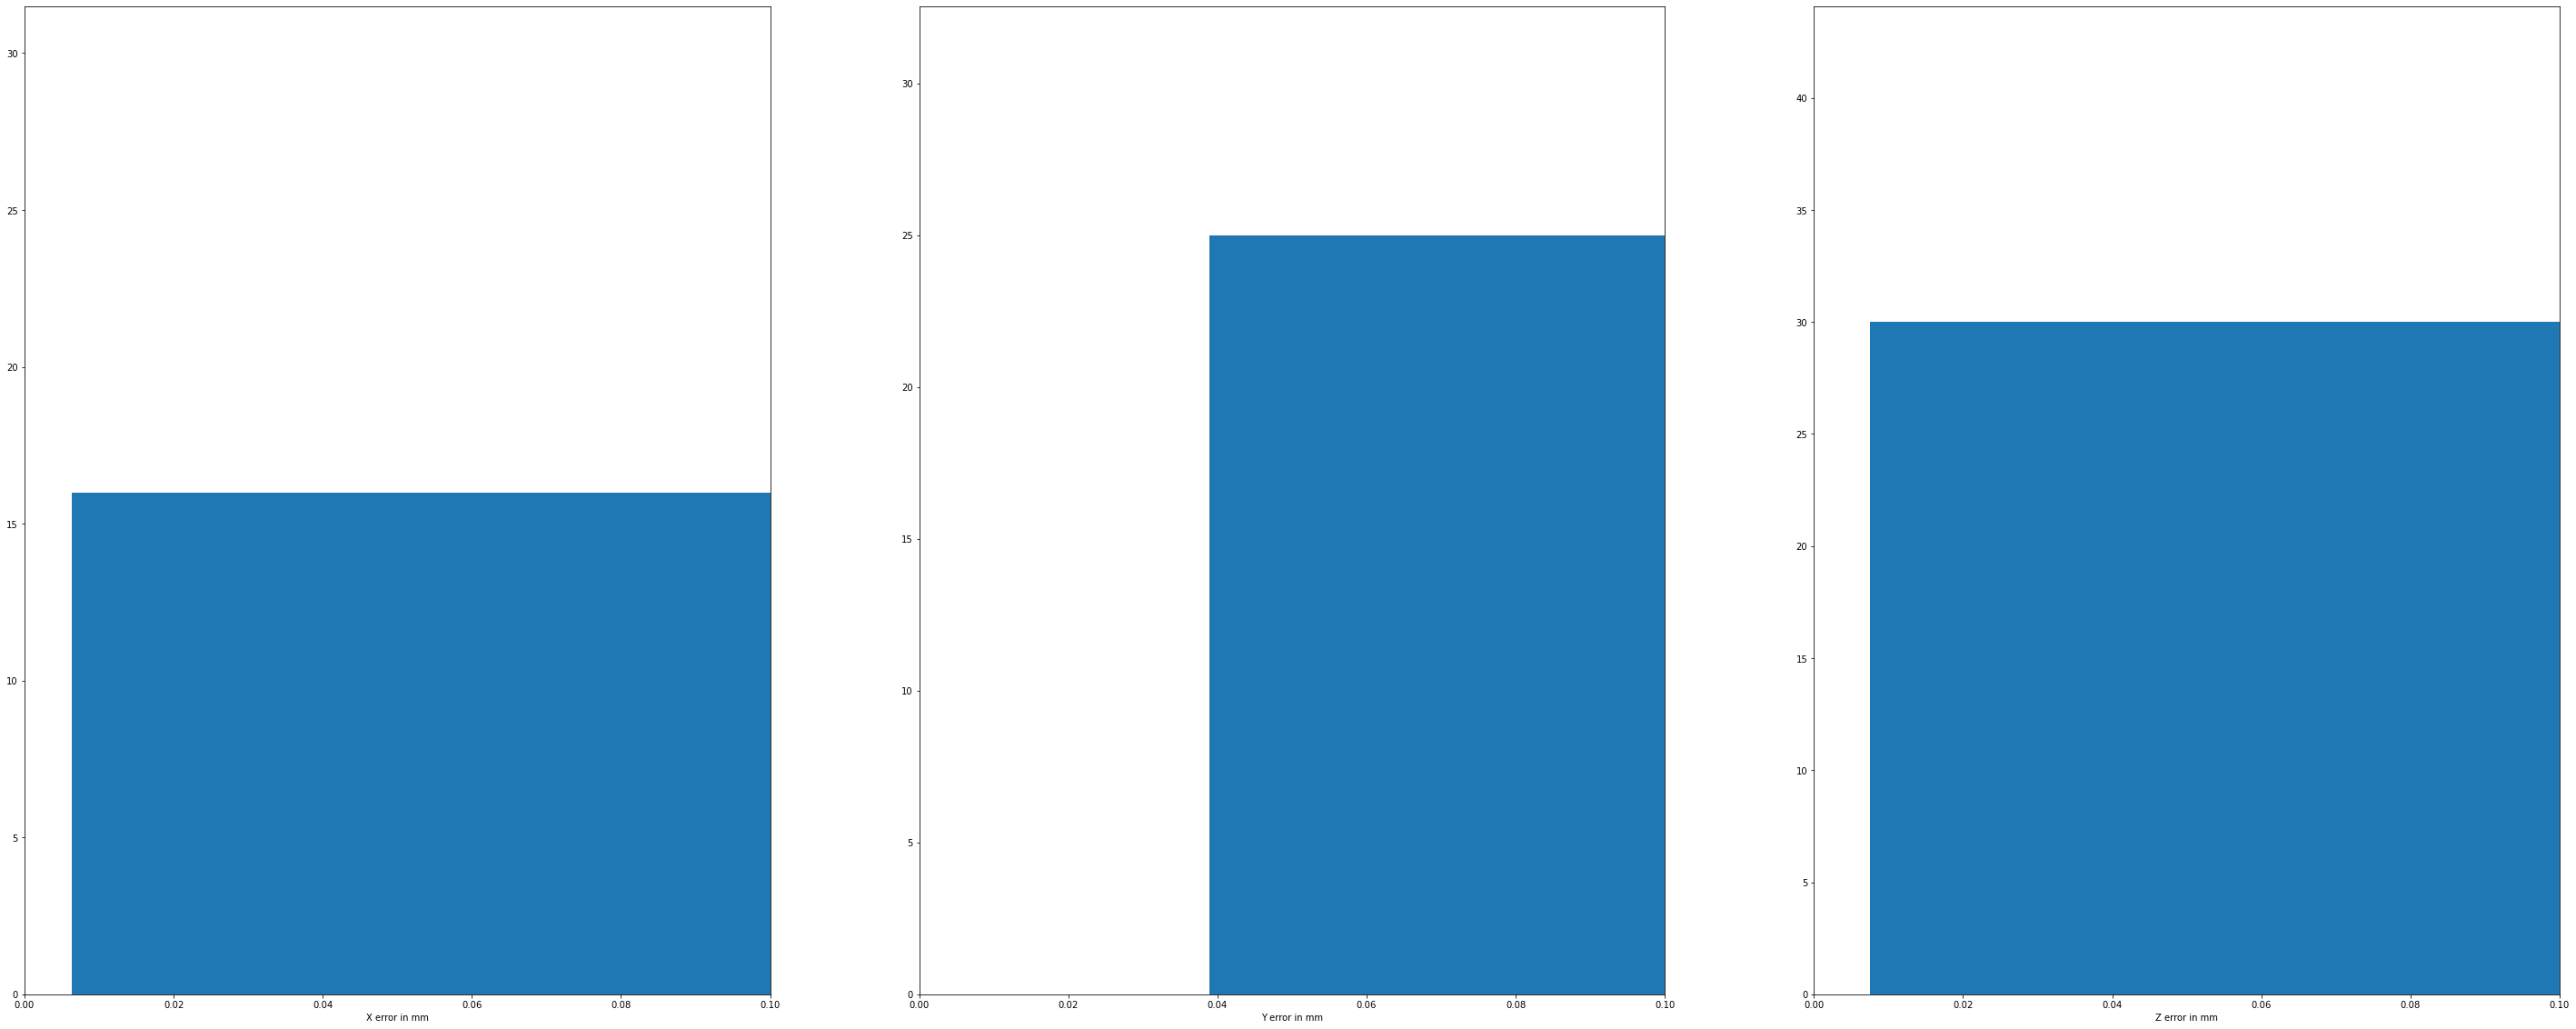

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 129.9586419719516           0.6241816142285131            29.37284650704525
Y 160.82056086359748          0.26377707477167767           31.40172140928253
Z 145.28258435985032          0.3435462845313308           19.895471608779346
Average absolute positional error in mm:  41.89926216464427


In [4]:
searchTheBest(2,30,size=0.1)

Looking at Dataset 1  with  6  input neurons.
Neurons: 299  Loss:  18.805167940553325


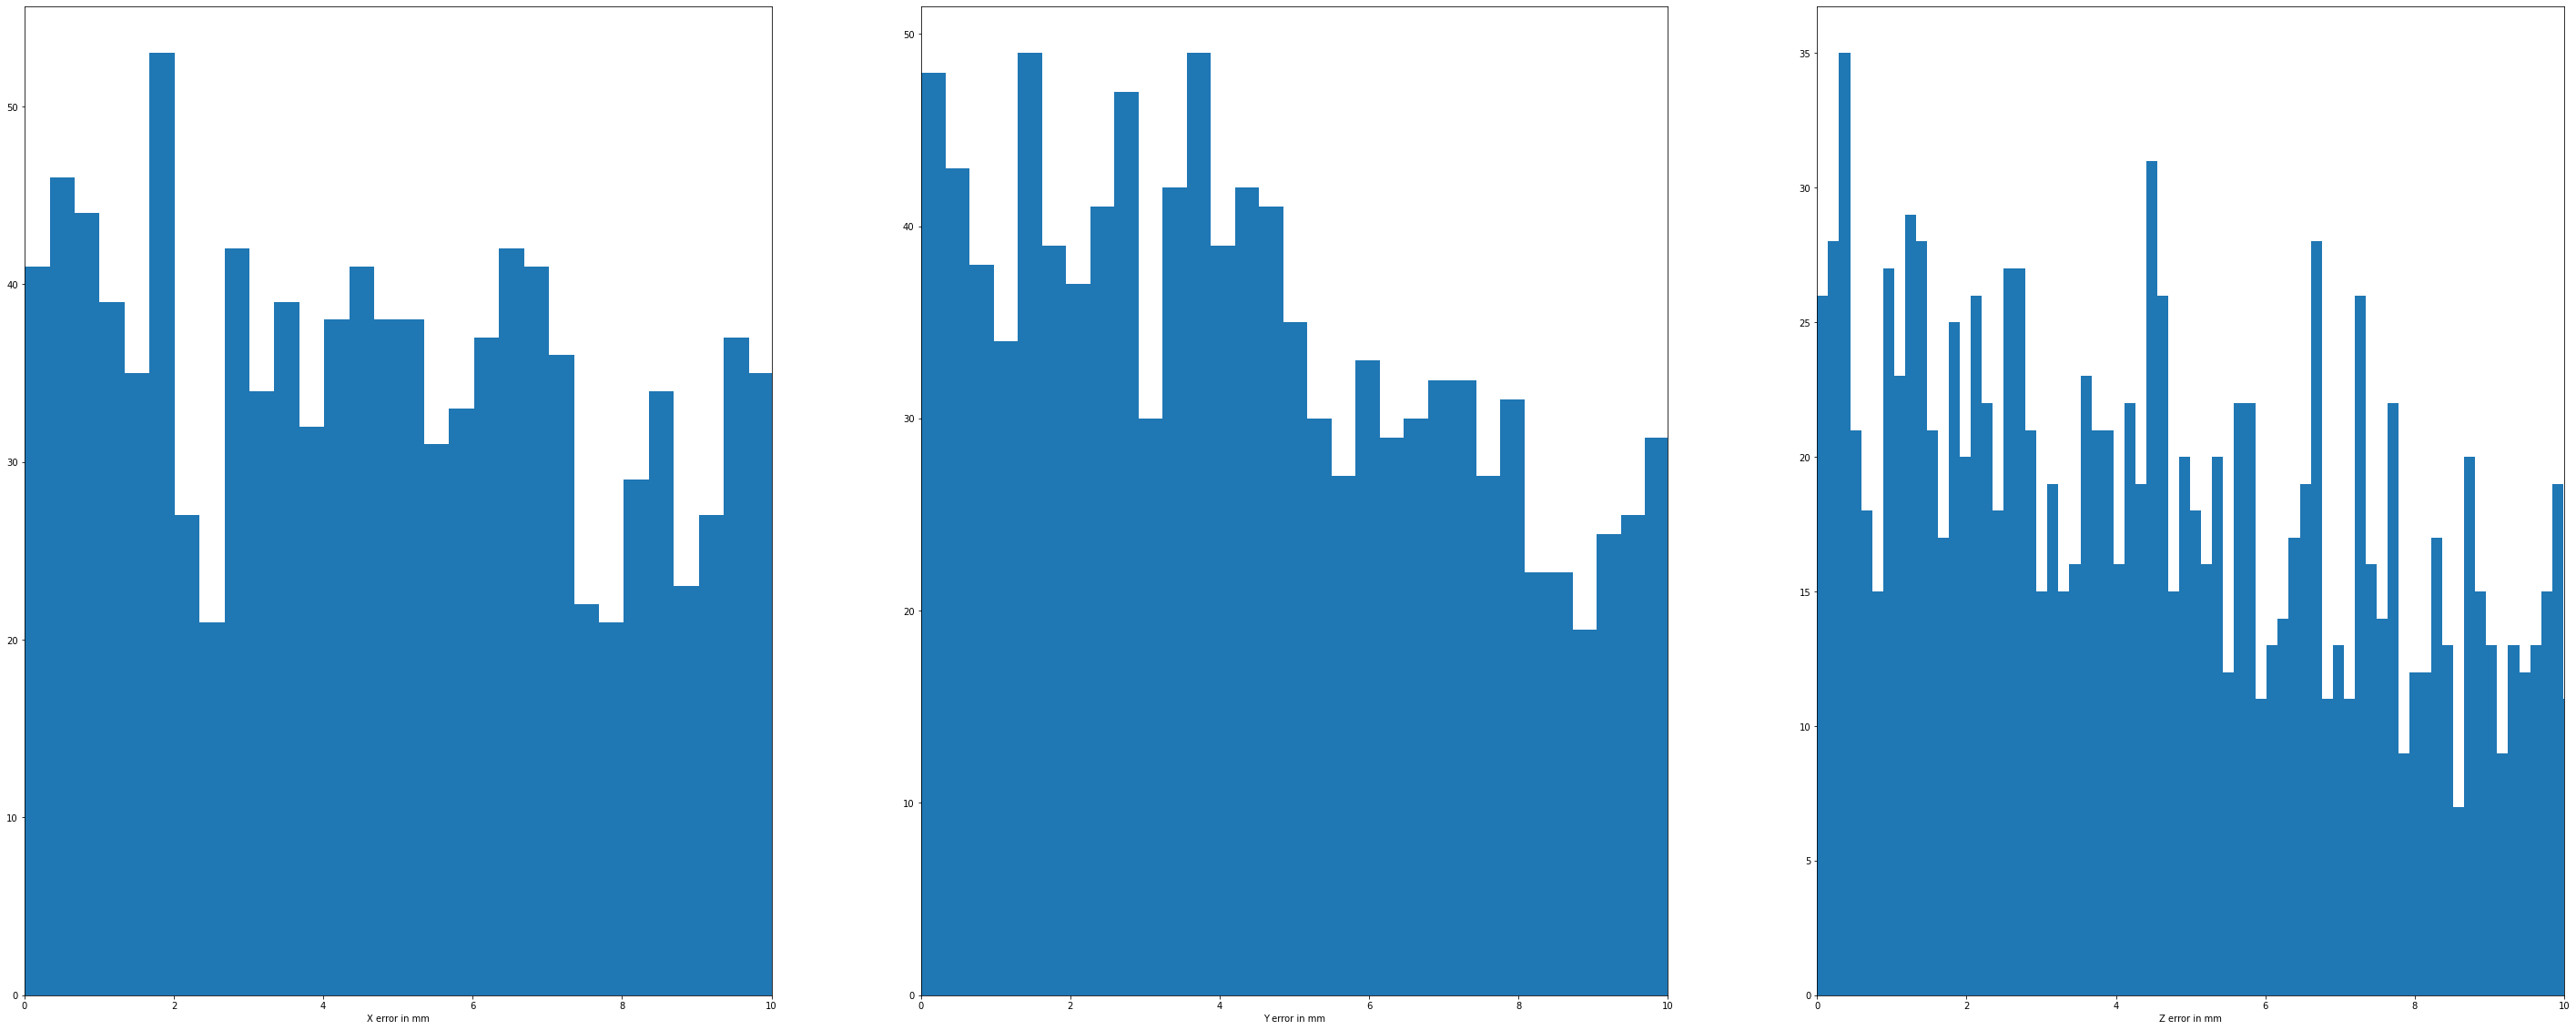

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 133.72464437189734          0.27615306450637106          16.720286450575532
Y 129.17625479100602         -0.36607766351854626          15.898515995112447
Z 58.73529567712854           -0.3169658711589089          10.691460042184184
Average absolute positional error in mm:  21.77741445695106


In [4]:
searchTheBest(1,70,size=10)

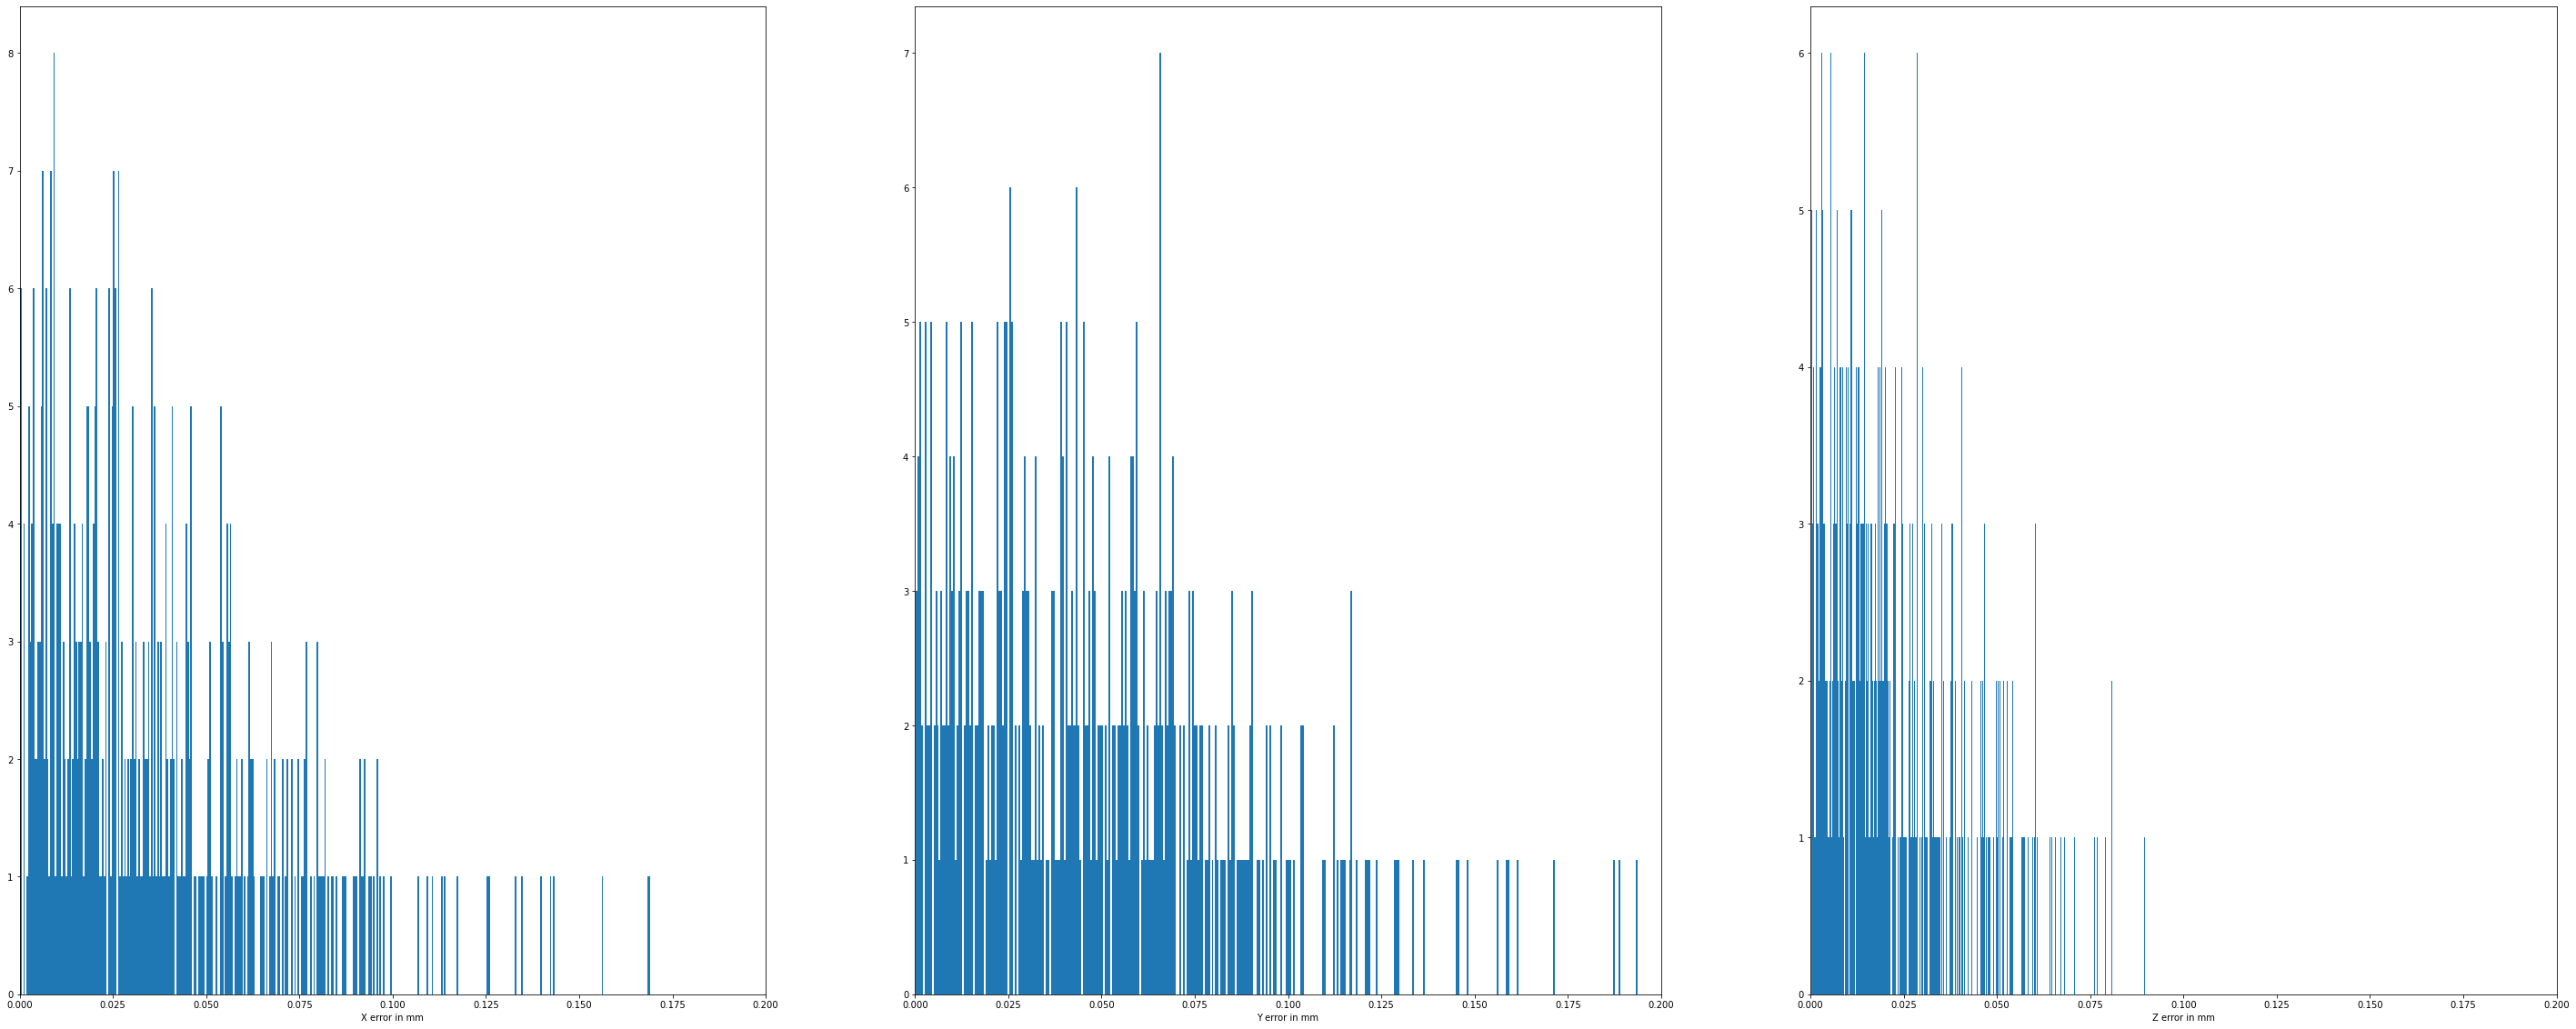

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.16911996831146803       0.00044921899103287423        0.04906590130951661
Y 0.19379197123758907        0.0004421691314977655        0.06163860660520452
Z 0.08965542223371425        0.002901868771832102         0.02822240914287419
Average absolute positional error in mm:  0.07536075588286284


In [5]:
trainDataSet(5,252,"normal",size=0.2)

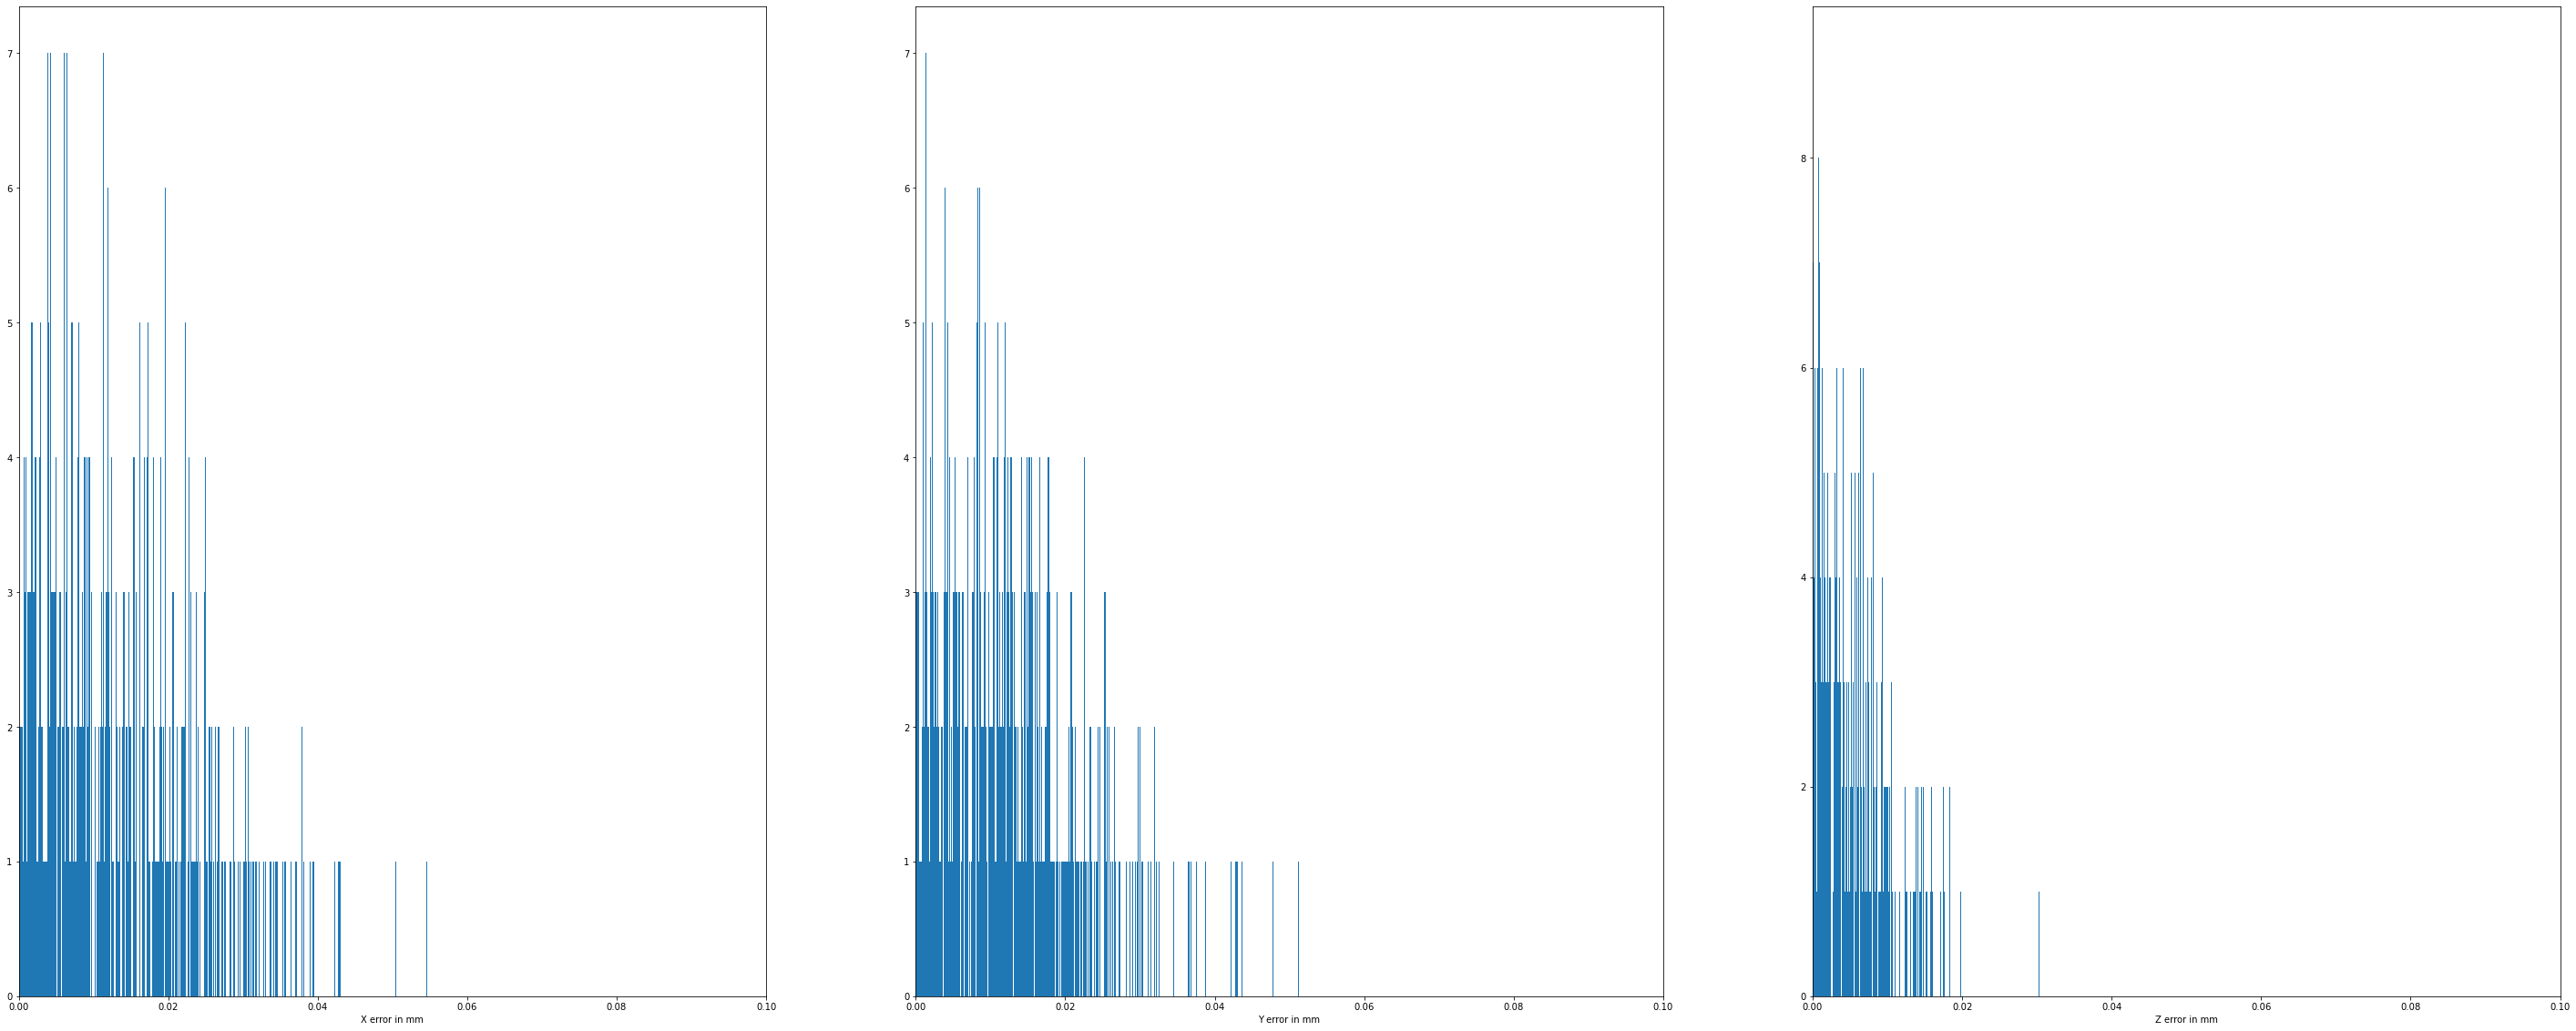

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.05460241697829993       0.00022577352042642775       0.016884630064666215
Y 0.05124399074518671        0.0002176888637617124       0.015540136398562837
Z 0.030342500324576083       0.000733038791194925        0.007236844991075075
Average absolute positional error in mm:  0.02184931307862704


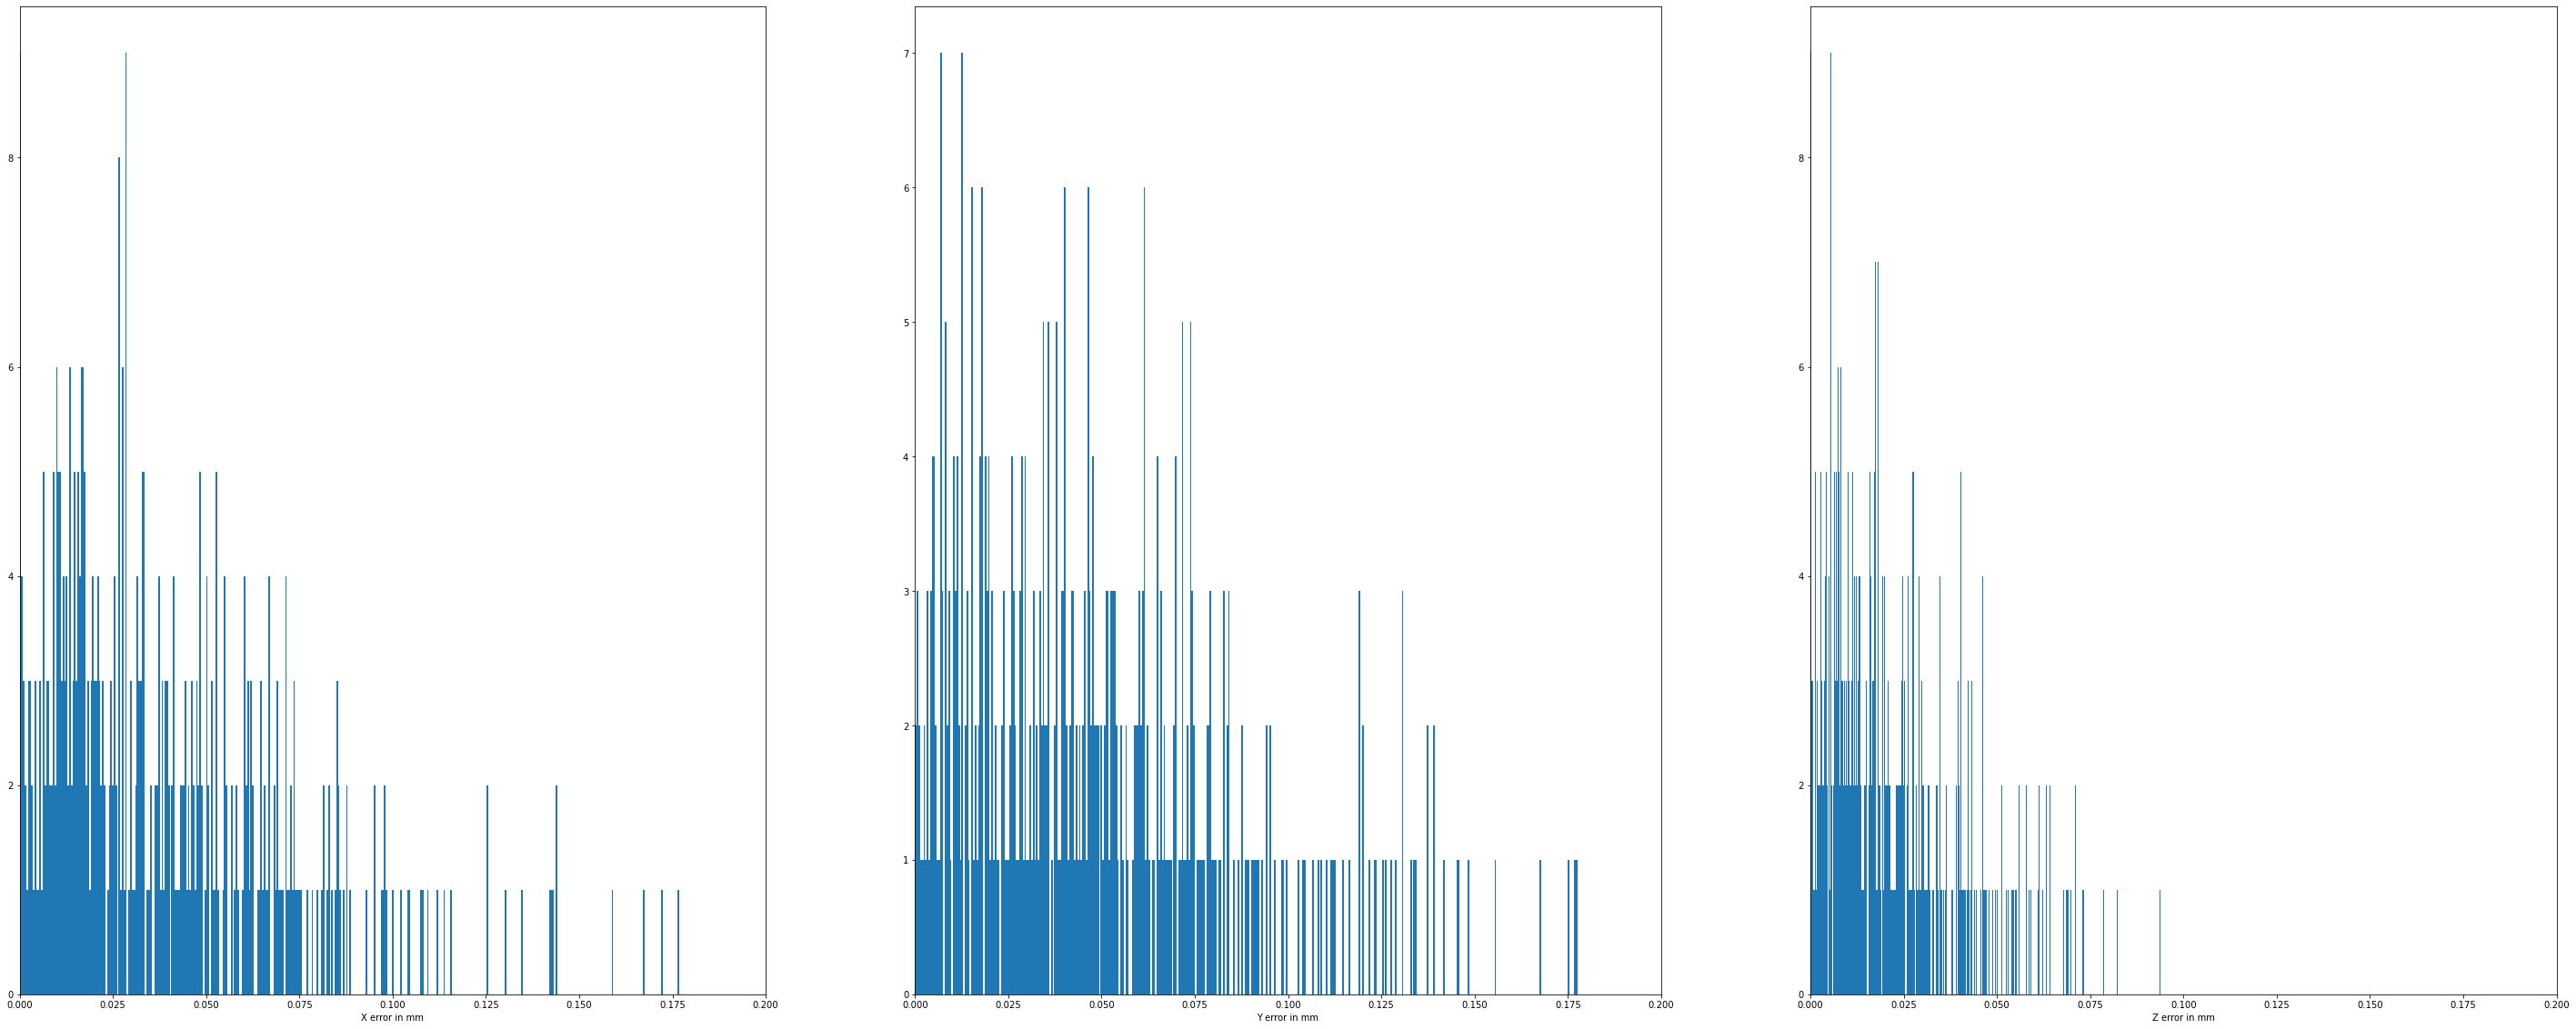

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.17679450851402265        0.0015667866373880283        0.05134778258602031
Y 0.17752501843093516        0.0006490071767638029        0.06168905456444973
Z 0.0937479850863232         0.0022799549669619877       0.028422734538699323
Average absolute positional error in mm:  0.07659692692741986


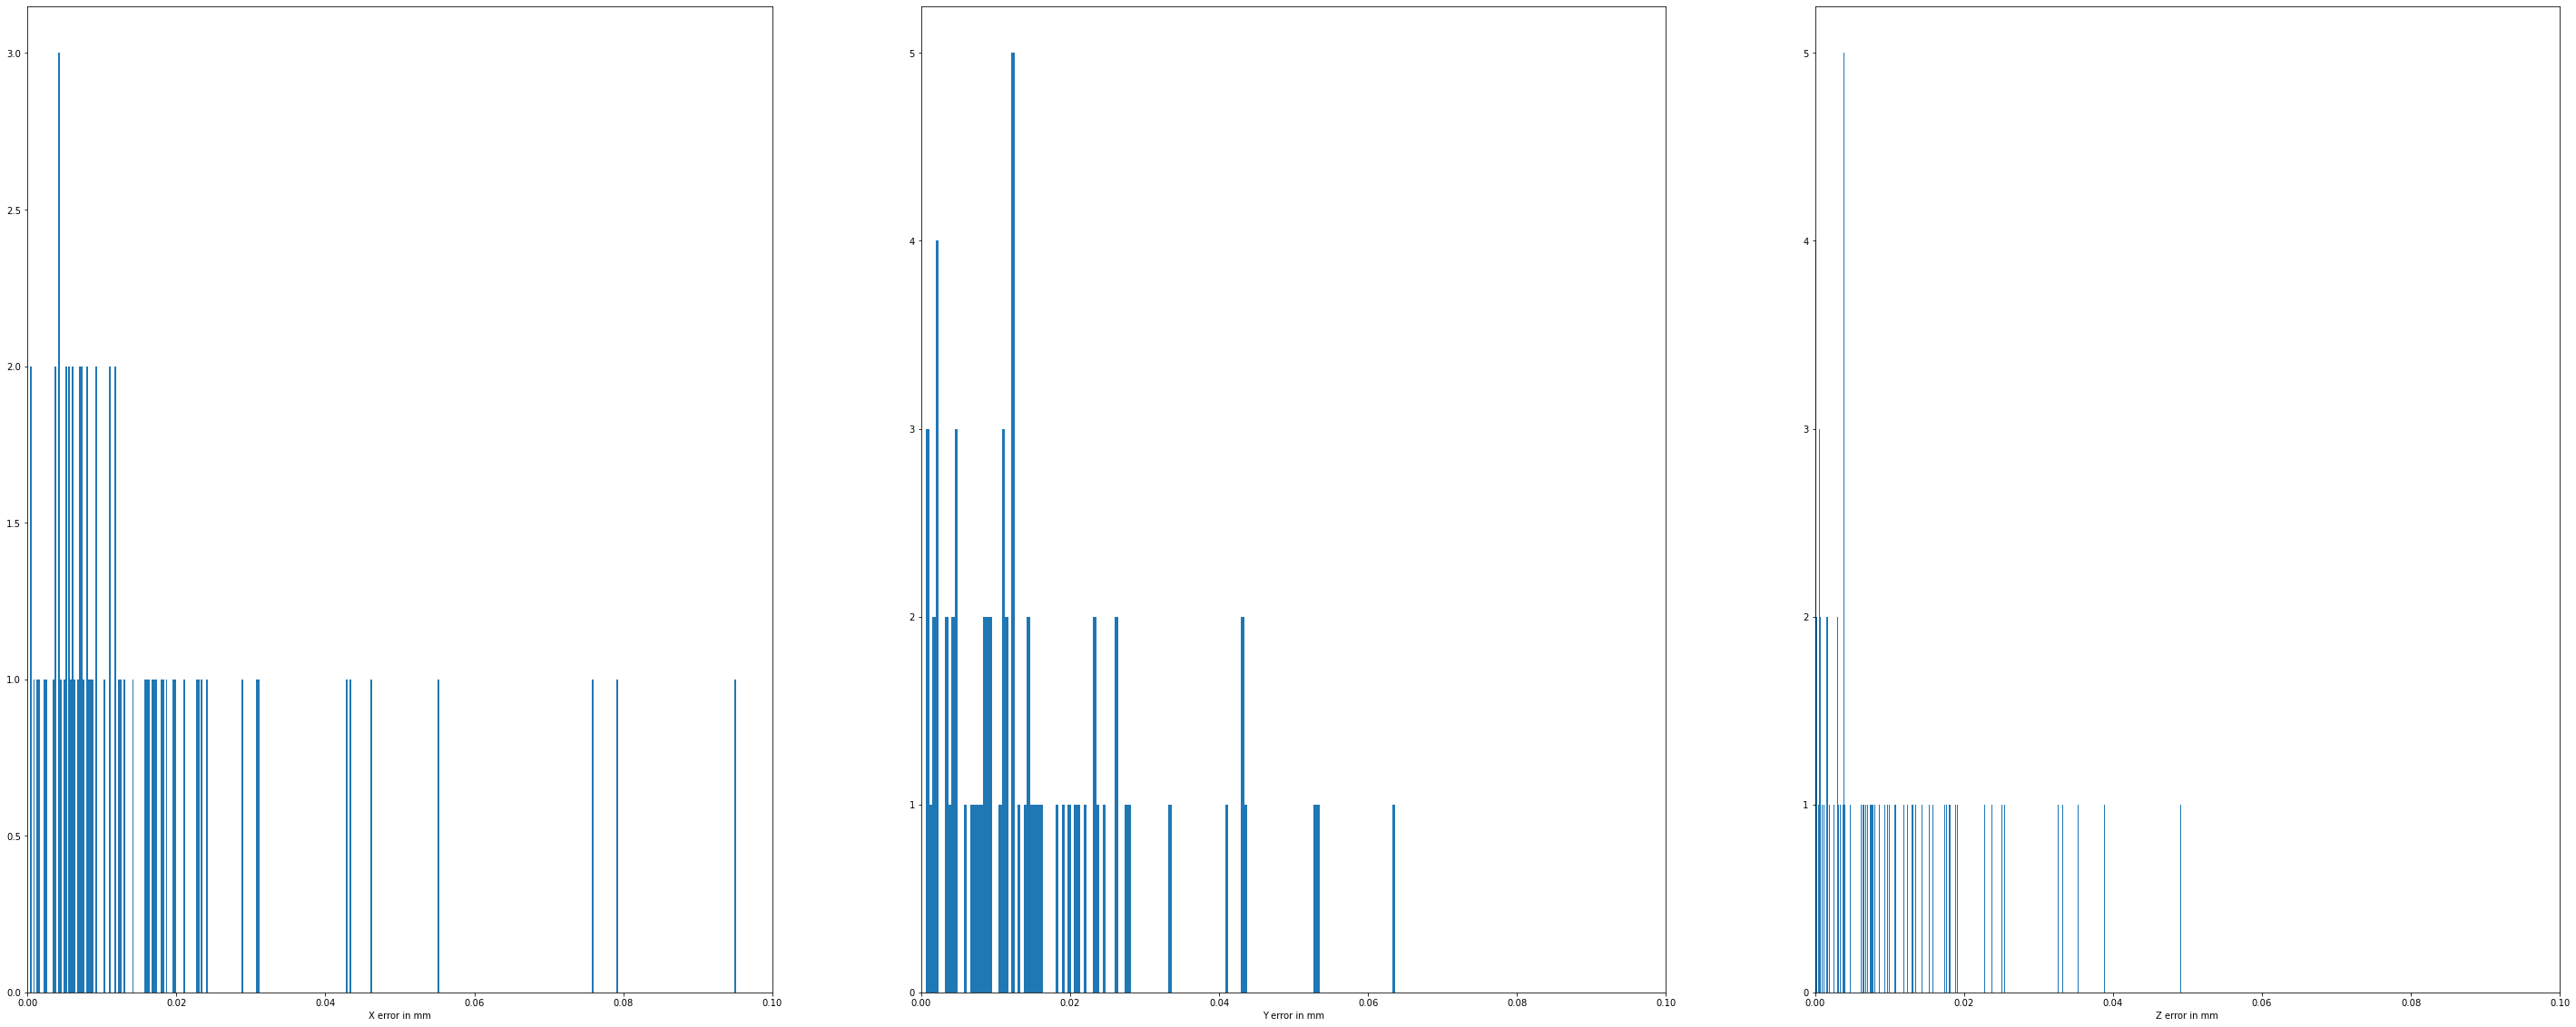

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.09518703939159767        0.004063202994887881        0.023779021489952607
Y 0.16970010382466594        8.471433092731198e-05        0.02873494109520953
Z 0.04918013778082431        0.0019265206812824221       0.014156745869619354
Average absolute positional error in mm:  0.029928933497684246


In [3]:
trainDataSet(4,234,"normal",size=0.1)
trainDataSet(5,252,"normal",size=0.2)
trainDataSet(6,77,"rand",size=0.1)

In [22]:
 loss("datasets/dataset1.csv",inputs=6,normalization="dataset1",neurons=6000,activation="sigmoid",distribution="normal",xlim=10)        

0.5777106810178165

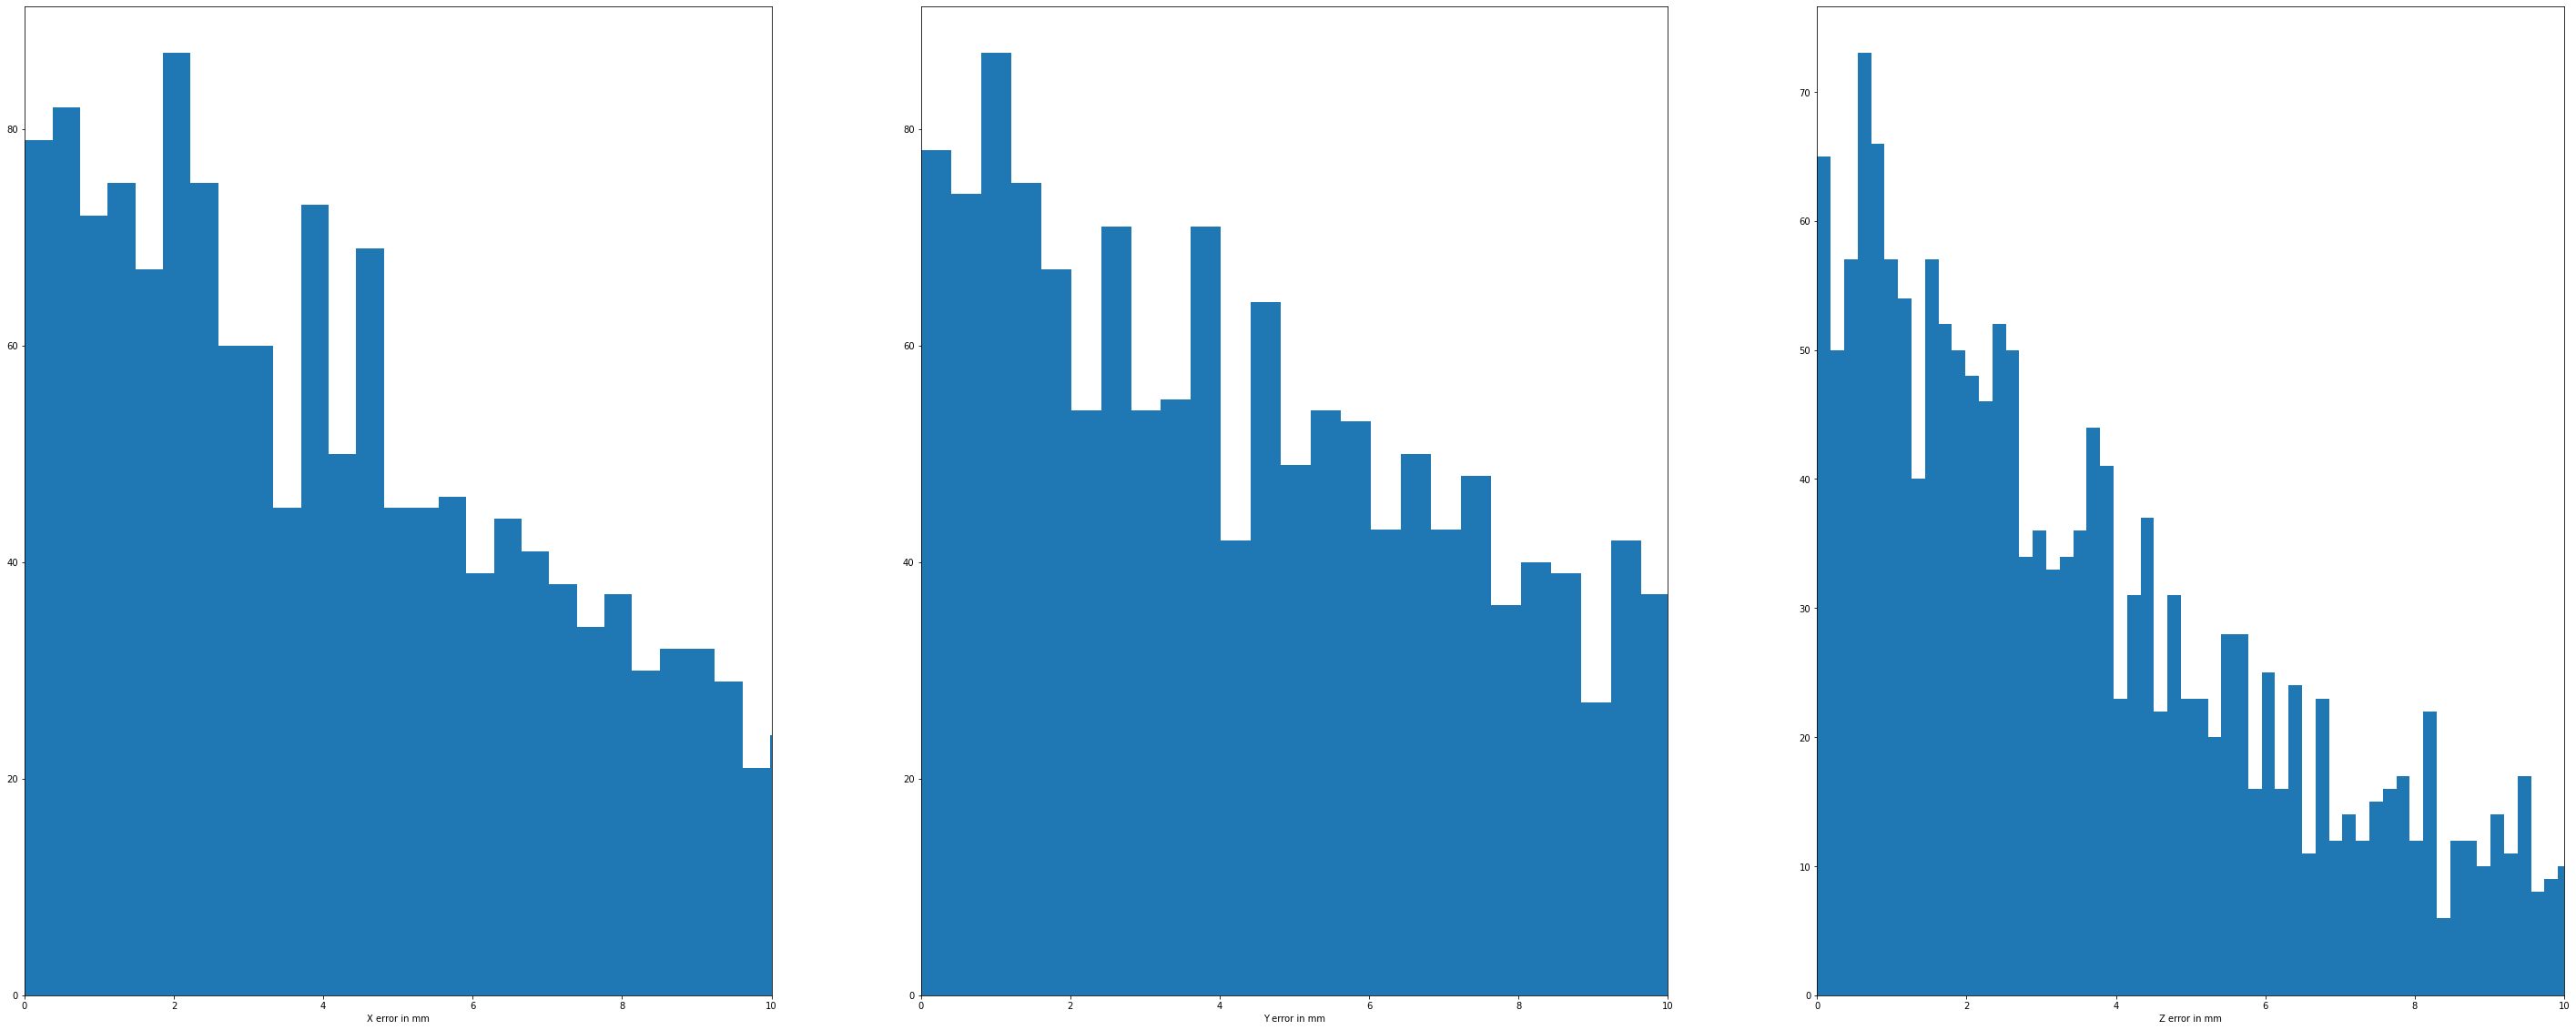

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 147.7913282385761           0.4460727069896984           14.040583058587536
Y 160.64727461225831         -0.18337332964122377          15.317240709434552
Z 72.11622245639526          -0.10134254789695558           9.060961296330417
Average absolute positional error in mm:  16.511372685479987


In [27]:
trainDataSet(2,6000,distribution="normal",size=10)

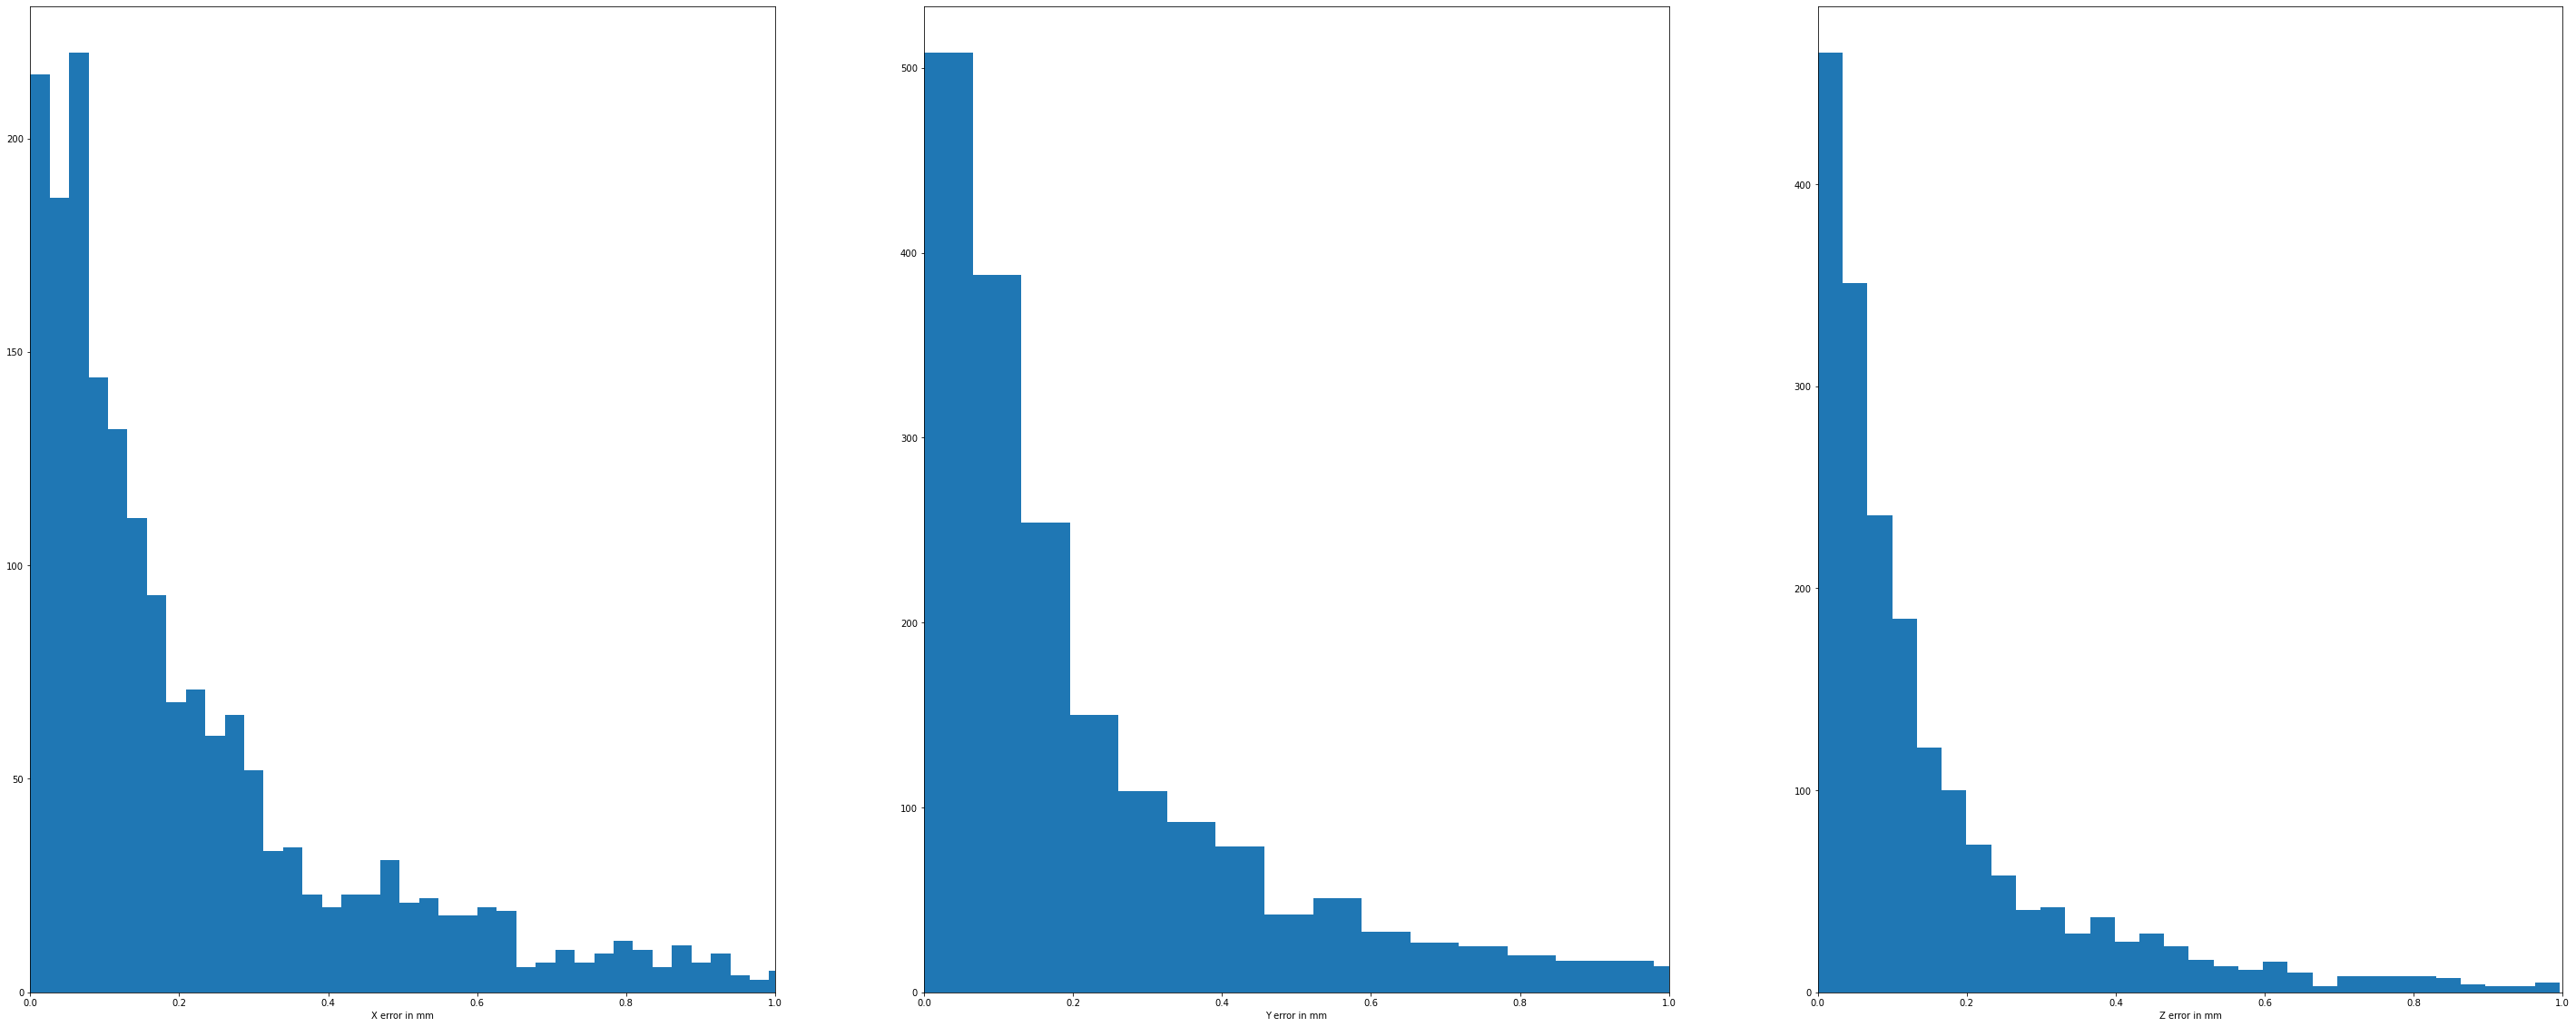

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 10.442259606829985         0.0007884225744848603          0.814472379328137
Y 26.11143833693197          -0.04536820143055551           1.180759333105341
Z 13.276646801002489        -1.4876000354548503e-05         0.583775568497287
Average absolute positional error in mm:  0.696931696999078


In [28]:
trainDataSet(1,6000,distribution="normal",size=1)

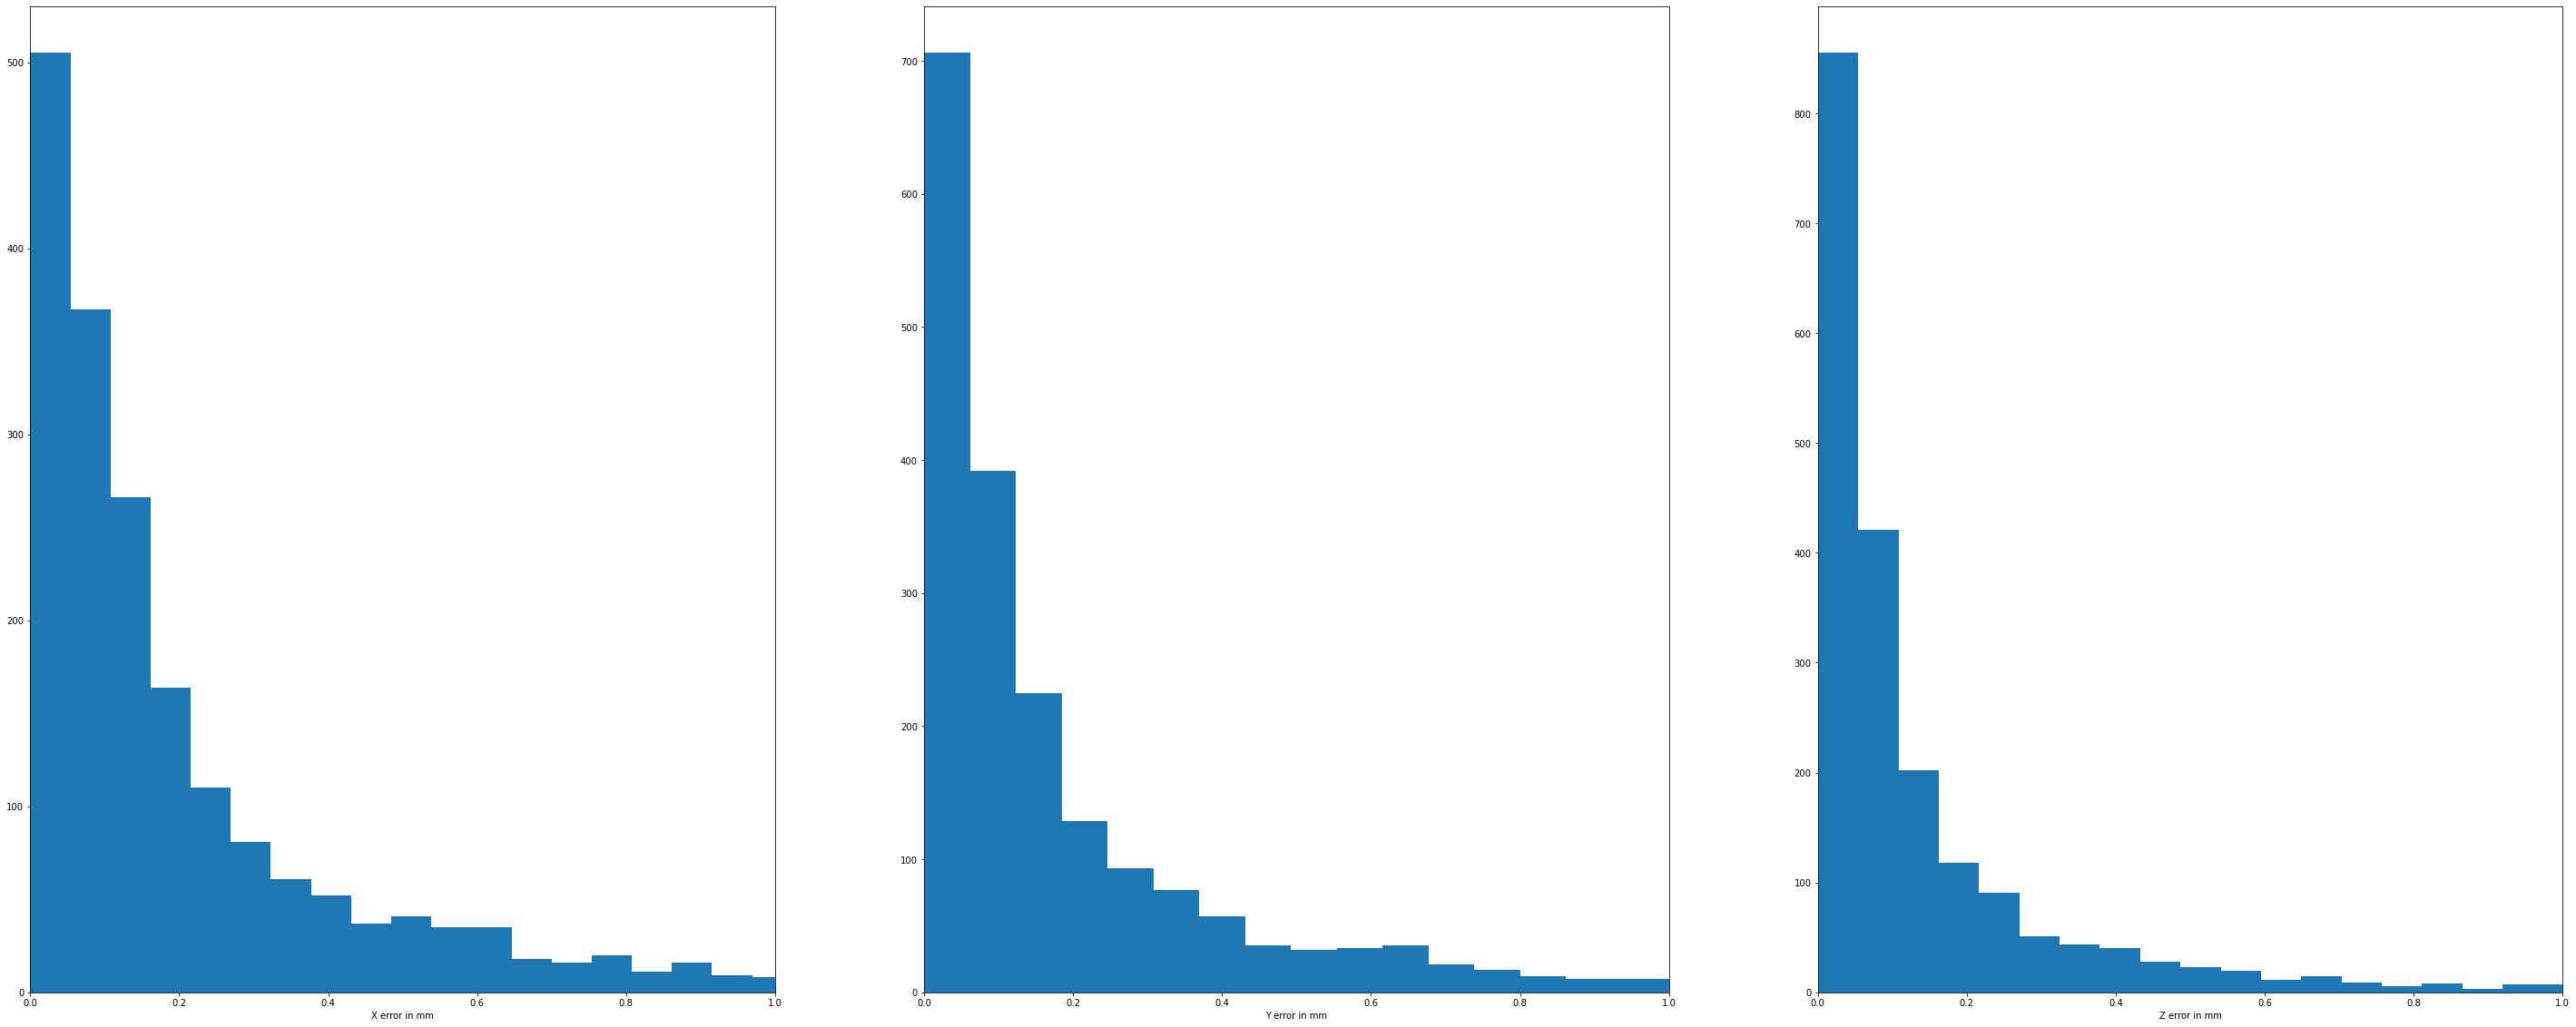

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 21.5363595593383           0.009486286306447274          0.9775709103831883
Y 24.615587364403613         -0.016803854021045516         1.0353048010156343
Z 21.633863112785534         0.011884419461776428          0.6358912218710305
Average absolute positional error in mm:  0.5743516632310046


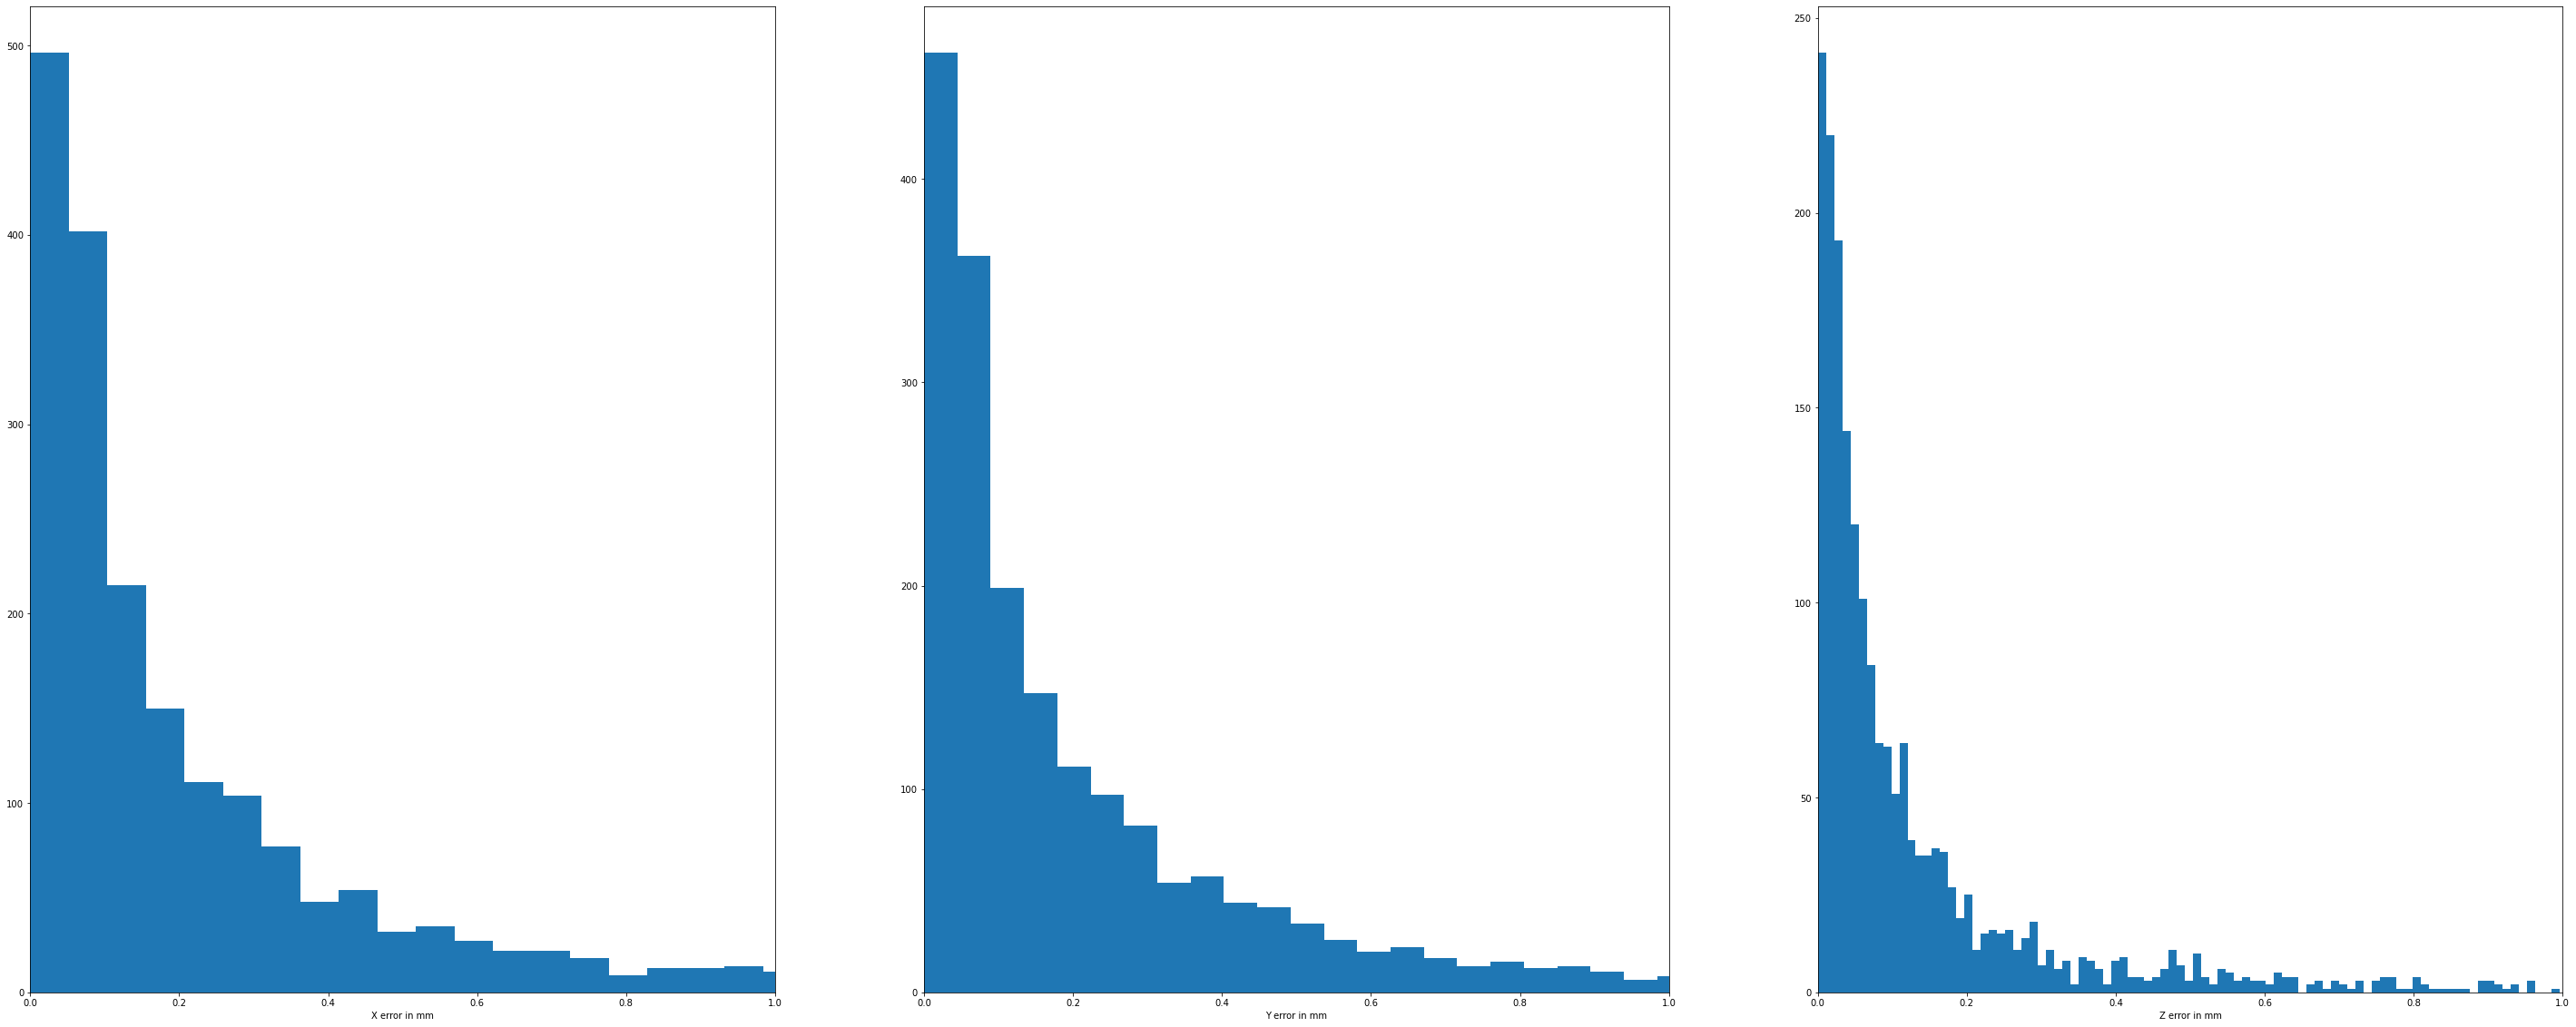

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 20.72082545006737           0.01057607269219429          0.9645915352716171
Y 17.89734163424439          -0.019458734843084195         0.9436545082920992
Z 4.375971981593341          0.0014738253629722174        0.40352429468119116
Average absolute positional error in mm:  0.6037515783925762


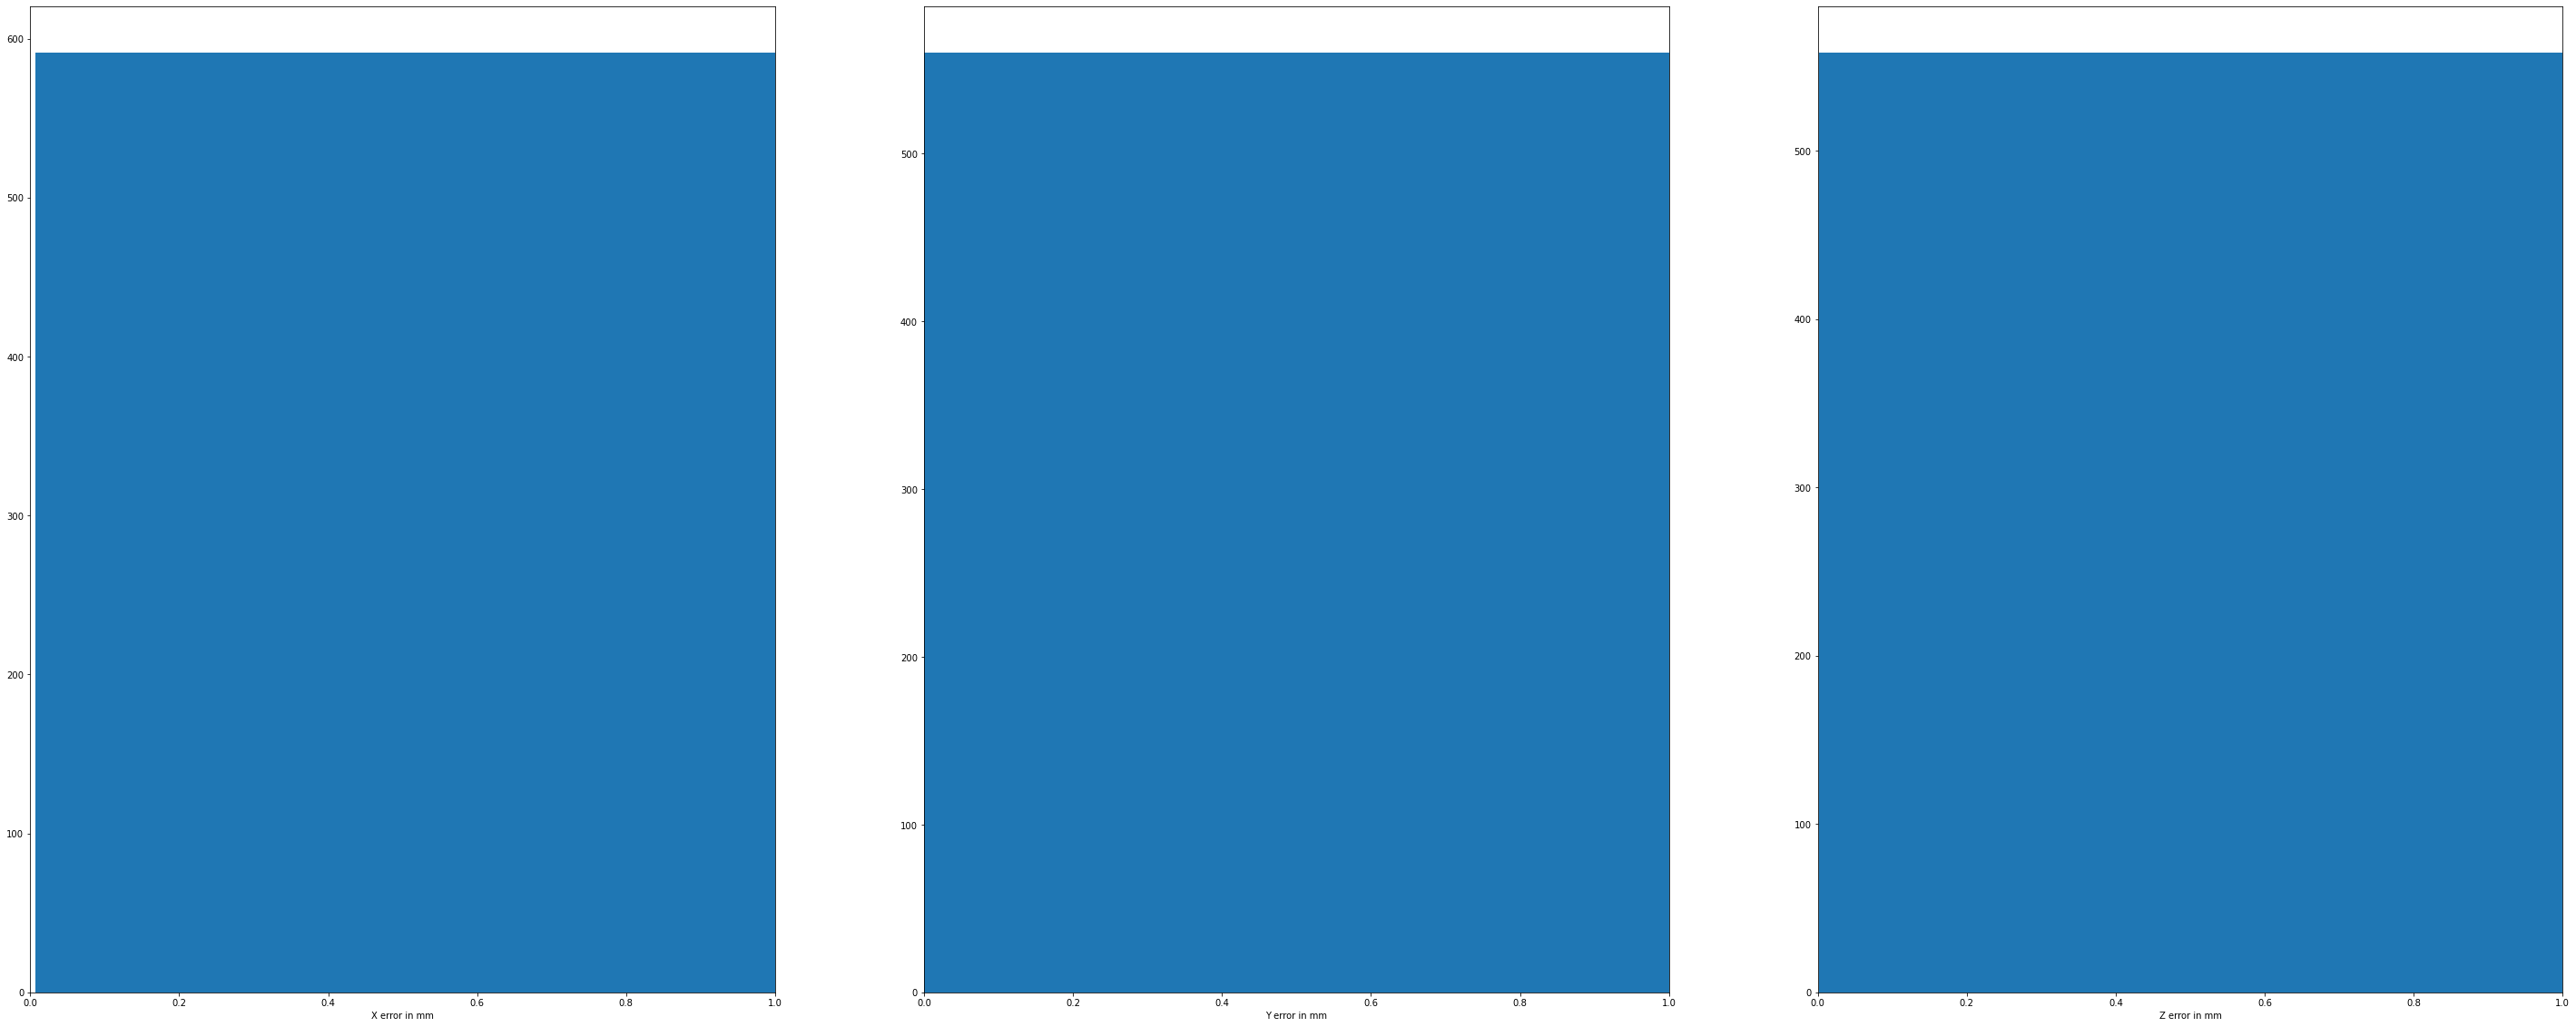

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 3404.5258908880337          -8.214899774810263           181.34697838917984
Y 797.7734969293628            1.659137186780373           49.901436142978525
Z 595.2996574468016           -1.5056215957716699           35.22330556593953
Average absolute positional error in mm:  64.5122356194239


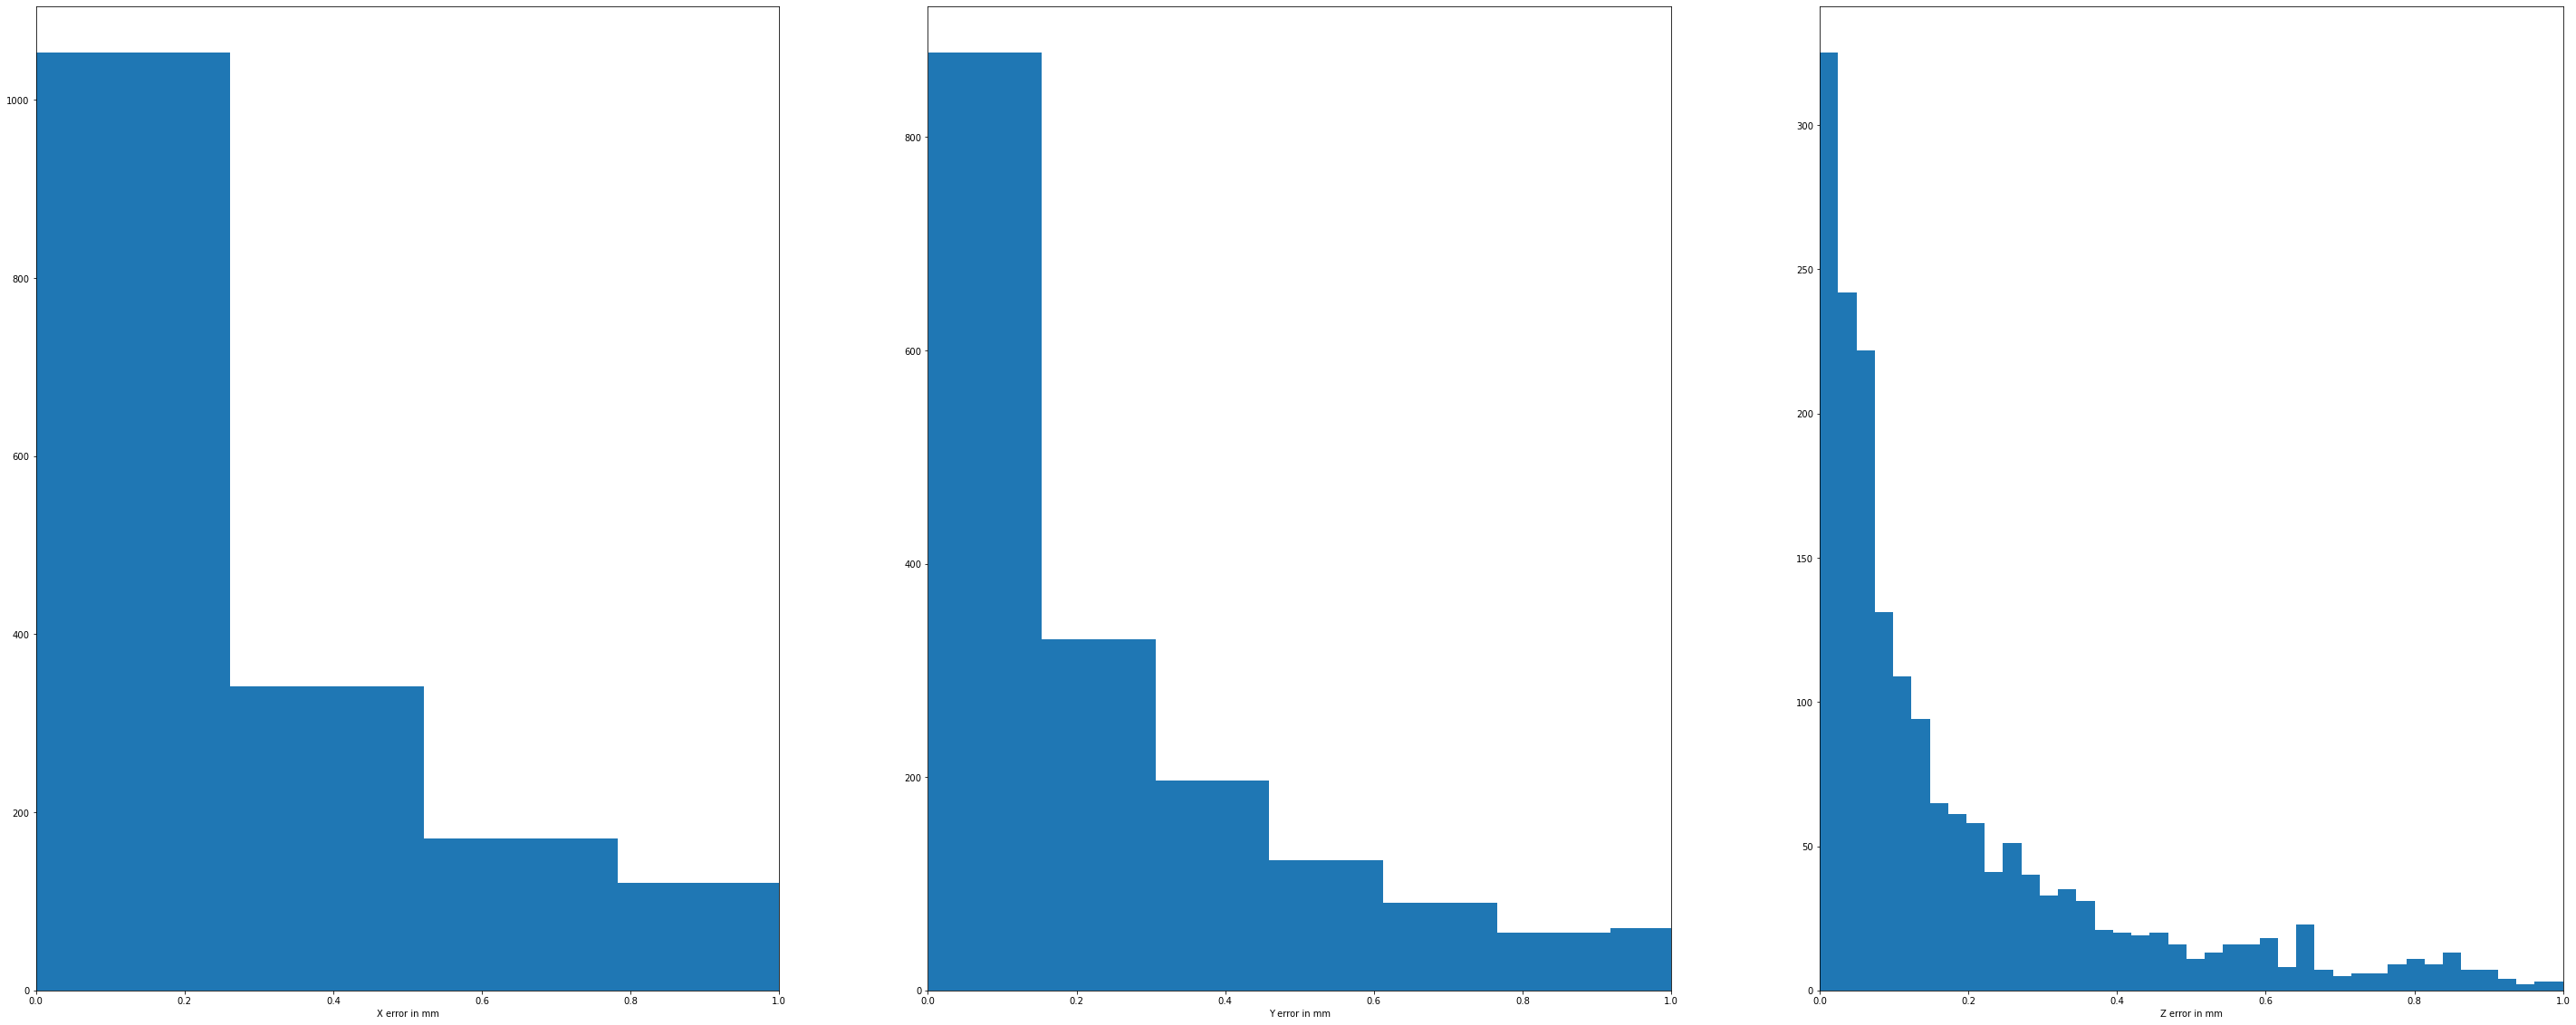

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 104.35200227166919          0.08050534636246139           2.984248439536294
Y 61.23100920188185          -0.12314040688085487          2.3149190823646446
Z 9.862009743079824          0.018636474920679935          0.8506720969571675
Average absolute positional error in mm:  1.2203428068699635


In [29]:
trainDataSet(1,6000,distribution="normal",size=1)
trainDataSet(1,7000,distribution="normal",size=1)
trainDataSet(1,8000,distribution="normal",size=1)
trainDataSet(1,9000,distribution="normal",size=1)

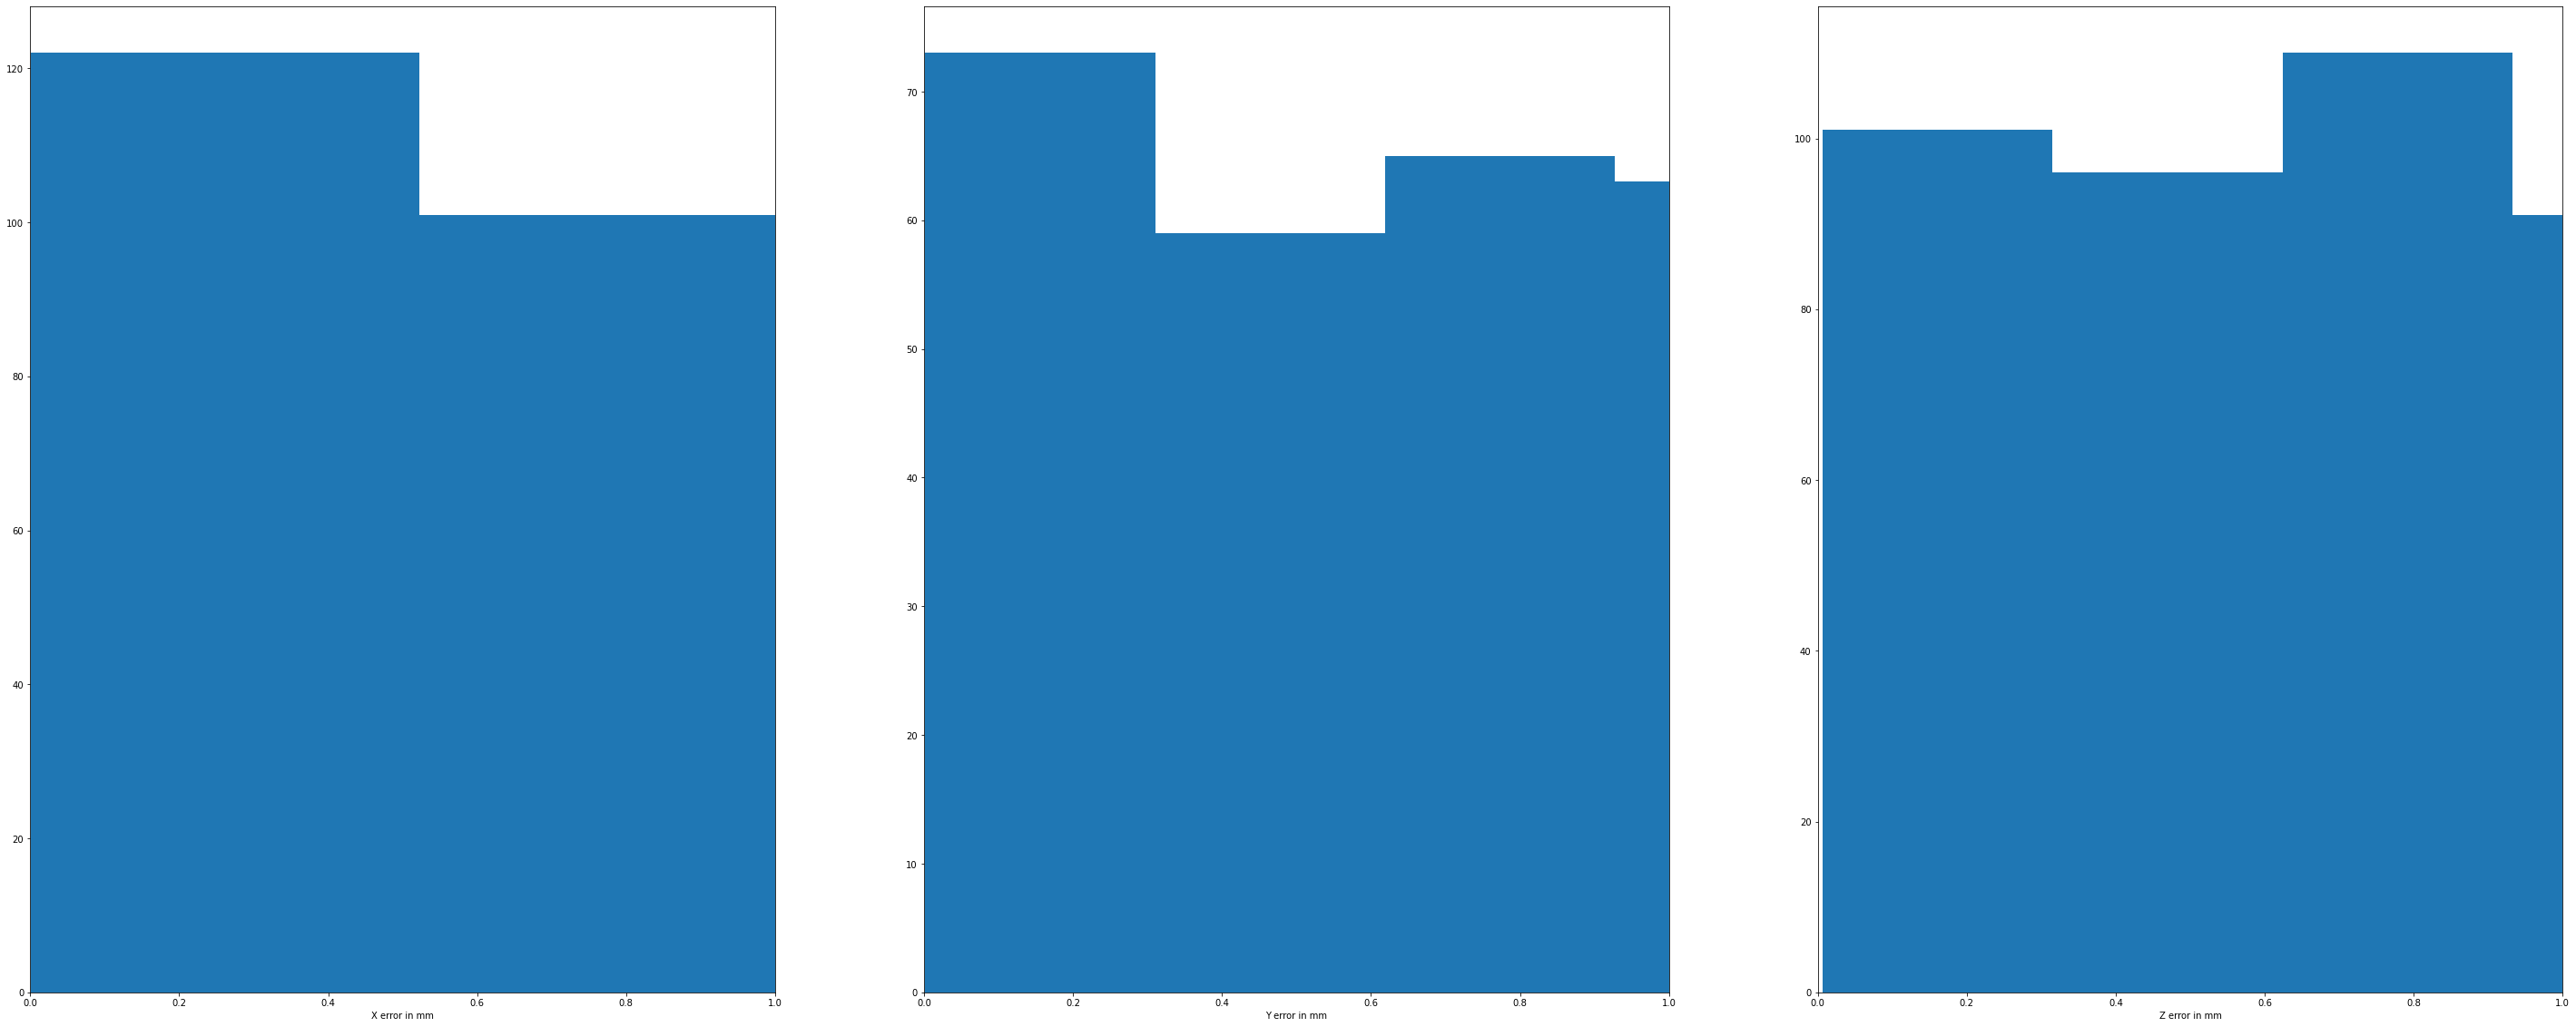

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 208.6744076962589          -0.08127662974255488           14.83057194945981
Y 123.42789776648394          0.8596213779696695           13.060599939832839
Z 123.52841975969986         0.012887166061798709           8.873895129918663
Average absolute positional error in mm:  15.796195076081029


In [31]:
trainDataSet(2,6000,distribution="normal",size=1)

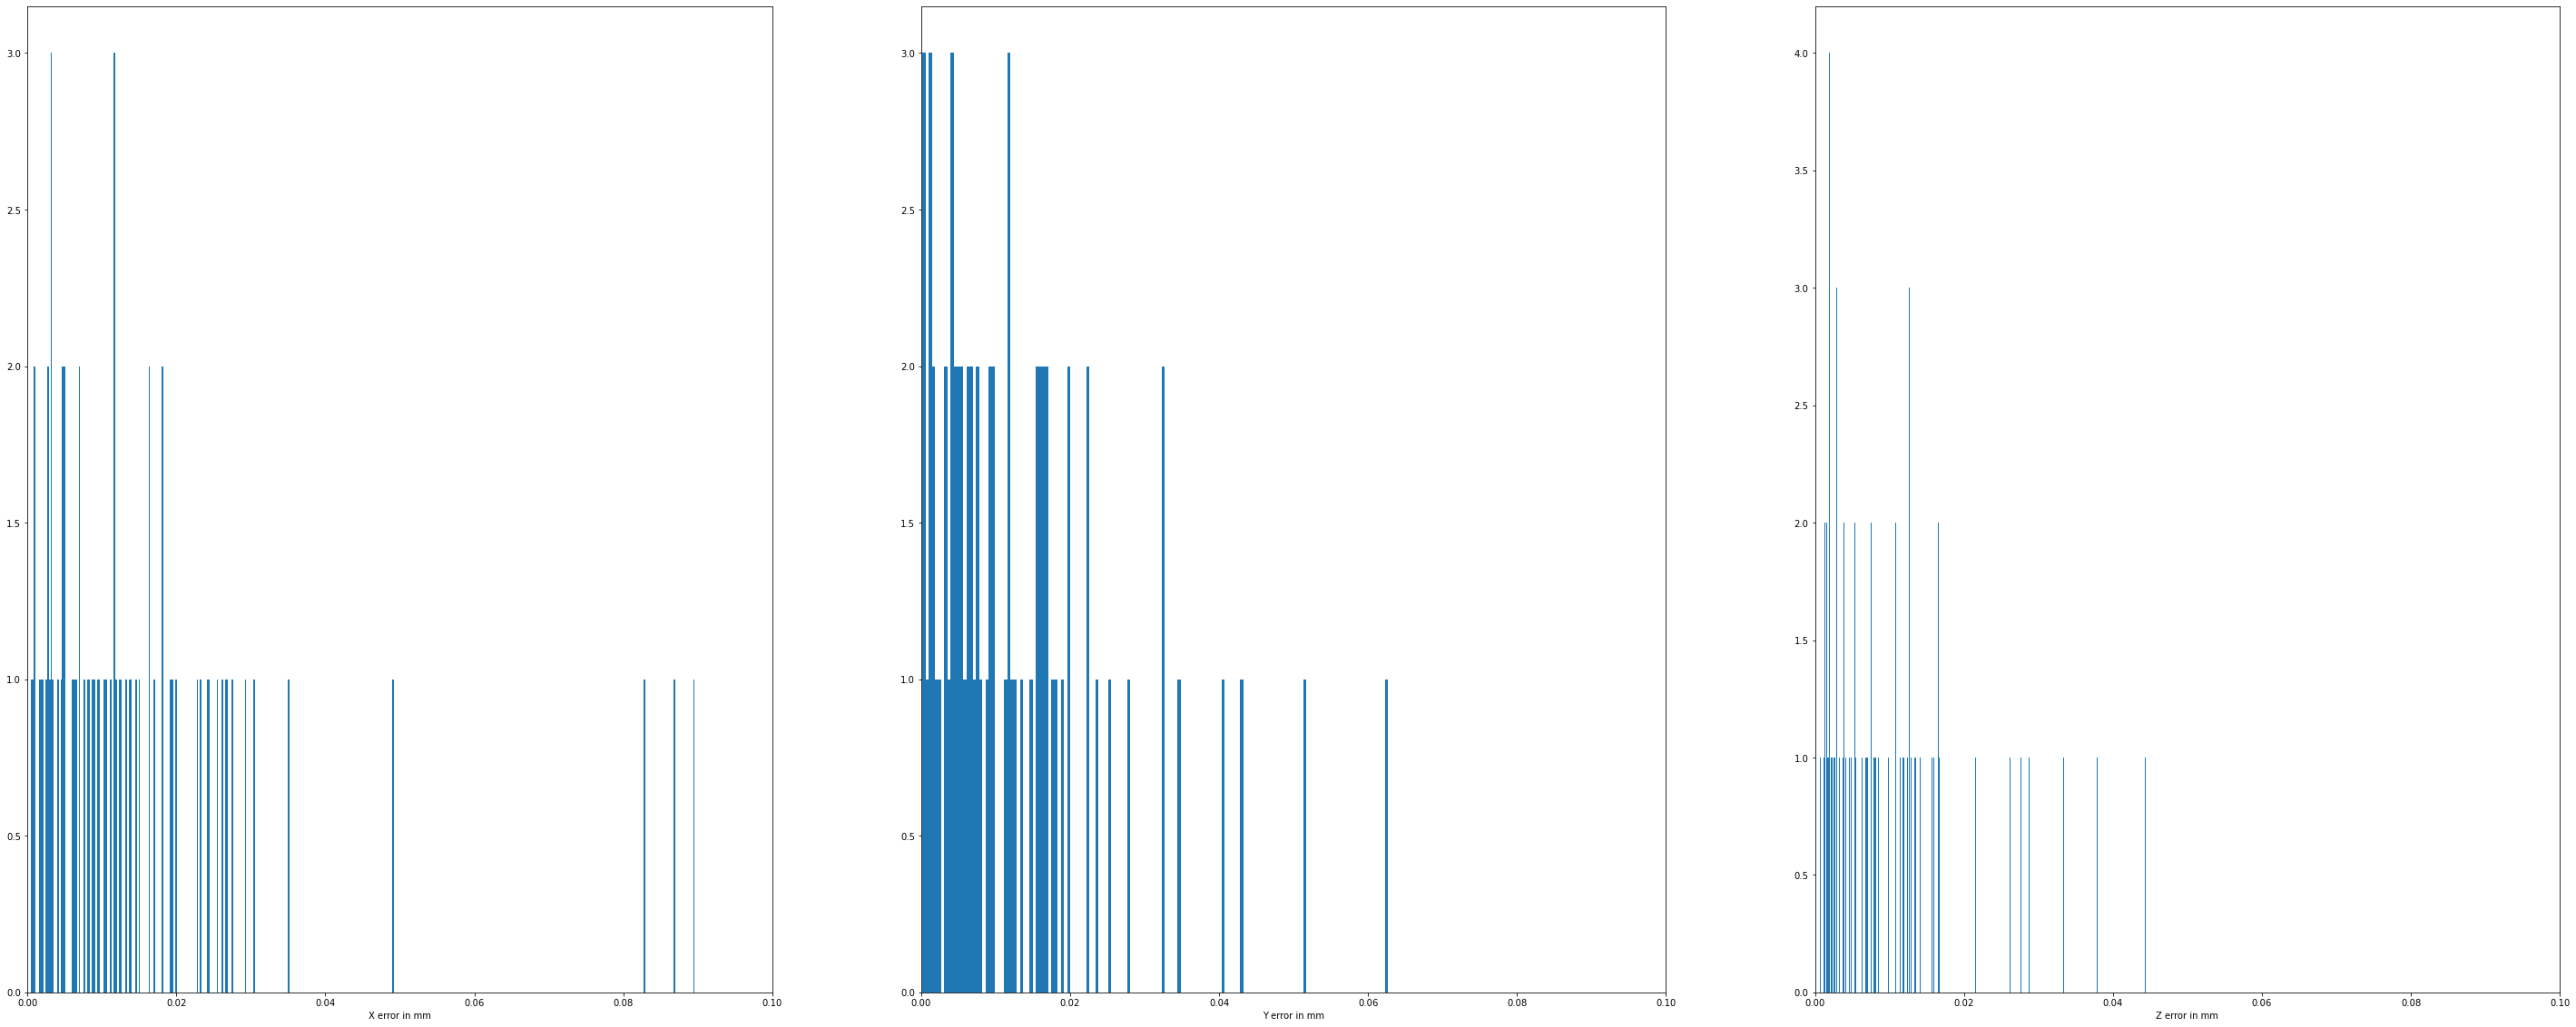

Maximum                            Mean                              StDerv
-----                              -----                              -----
X 0.08960565131371778        0.0017705150531530218        0.02350009393332337
Y 0.16917325769366665        0.0016025825427429174        0.02681885475963906
Z 0.044418789221734034       0.0011828202492138193       0.012941135866184793
Average absolute positional error in mm:  0.02803918899218902


In [7]:
trainDataSet(6,80,"rand",size=0.1)